# Оптимизация производственных расходов металлургического комбината

**Цели:**

* Оптимизировать производственные расходы металлургического комбината за счет уменьшения потребление электроэнергии на этапе обработки стали.
* Построить модель, которая предскажет температуру стали на финальном этапе.
* Для каждого значения столбца key найдите:
    * Длительность времени между первым и последним замером температуры.
    * Суммарное время нагрева электродами, то есть сумму значений по всем промежуткам между запусками нагрева электродов.
    * Среднее соотношение потребления активной и реактивной мощности.

### План решения задачи

1. **EDA**. Обработка аномалий, пропусков и генерация новых фичей на основе имеющихся данных. Составление единого датафрема с индексом key.
2. **Моделирование**. Разбиение на тестовую и тренировочную выборку. Расчет таргета на нескольких моделях.
3. **Доводка**. Корректировка фичей, кросс-валидация и подбор гиперпараметров для лучшей модели. Проверка на константной модели sklearn.dummy.DummyRegressor.
4. **Составление отчета**. Определение основных признаков оказывающих влияние на температуру.

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

# Загрузка и подготовка данных

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Lasso, LassoCV
from sklearn.dummy import DummyRegressor

import optuna
from catboost import Pool, CatBoostRegressor
import lightgbm as lgb

In [2]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

pd.options.display.float_format = '{:0.3f}'.format
pd.options.mode.chained_assignment = None
pd.set_option('display.expand_frame_repr', False)

sns.set_theme(context='paper',
              palette='muted',
              style='whitegrid',
              font_scale=1.1,)

plt.rcParams.update({'lines.linewidth': 1.25,
                     'grid.linewidth': 0.5,
                     'grid.alpha': 0.5,
                     'figure.constrained_layout.use': True,
                     'figure.figsize': (10, 6)})

%config InlineBackend.figure_format = 'retina'

In [3]:
random_state = 290822
test_size = 0.25

Загрузим файлы из /datasets/final_steel/ или локального хранилища.

In [4]:
url = '/datasets/final_steel/'
files = glob.glob(os.path.join(url, '*.csv'))
if files == []:
    path = r'.\data'
    files = glob.glob(os.path.join(path, '*.csv'))

files

['.\\data\\data_arc.csv',
 '.\\data\\data_bulk.csv',
 '.\\data\\data_bulk_time.csv',
 '.\\data\\data_gas.csv',
 '.\\data\\data_temp.csv',
 '.\\data\\data_wire.csv',
 '.\\data\\data_wire_time.csv']

In [5]:
arc = pd.read_csv(files[0], parse_dates=[1,2])
bulk = pd.read_csv(files[1])
bulk_time = pd.read_csv(files[2], parse_dates=list(range(1,16)))
gas = pd.read_csv(files[3])
temp  = pd.read_csv(files[4], parse_dates=[1])
wire = pd.read_csv(files[5])
wire_time = pd.read_csv(files[6], parse_dates=list(range(1,10)))

Приведем названия признаков к pythonic way.

In [6]:
arc = arc.rename(columns={
    'Начало нагрева дугой': 'arc_heating_start',
    'Конец нагрева дугой': 'arc_heating_end',
    'Активная мощность': 'active_power',
    'Реактивная мощность': 'reactive_power',
})

gas = gas.rename(columns={
    'Газ 1': 'gas_1',
})

temp = temp.rename(columns={
    'Время замера': 'measurement_time',
    'Температура': 'temp',
})

bulk.columns = bulk.columns.str.lower().str.replace(' ', '_')
bulk_time.columns = bulk_time.columns.str.lower().str.replace(' ', '_')
wire.columns = wire.columns.str.lower().str.replace(' ', '_')
wire_time.columns = wire_time.columns.str.lower().str.replace(' ', '_')

# Исследовательский анализ данных

Вспомогательная функция для анализа. 

In [7]:
def describe(df):
    display(
        df.describe(include=[np.number, object]))
    
    print()
    print('Полные дубликаты:', arc.duplicated().sum())
    print()
    
    df.isna().mean().sort_values().plot(kind='barh',
                                        figsize=(10, 3 + len(df.columns) // 6),
                                        xlim=(0, 1),
                                        xticks=np.linspace(0, 1, 11));

В работе должны учитываться только партии, key которых присутствует во всех таблицах.

> Выделим такие ключи.

In [8]:
keys = set(arc.key.unique()).intersection(bulk.key.unique(), bulk_time.key.unique(), gas.key.unique(),
                                          temp.key.unique(), wire.key.unique(), wire_time.key.unique())
len(keys)

3022

In [9]:
arc = arc.query('key in @keys')
bulk = bulk.query('key in @keys')
bulk_time = bulk_time.query('key in @keys')
gas = gas.query('key in @keys')
temp = temp.query('key in @keys')
wire = wire.query('key in @keys')
wire_time = wire_time.query('key in @keys')

## Рассмотрим данные об электродах

,key,active_power,reactive_power
count,14200.000,14200.000,14200.000
mean,1615.740,0.665,0.447
std,931.804,0.400,6.016
min,1.000,0.030,-715.505
25%,808.750,0.395,0.290
50%,1613.000,0.556,0.416
75%,2427.000,0.849,0.632
max,3241.000,3.732,2.676



Полные дубликаты: 0



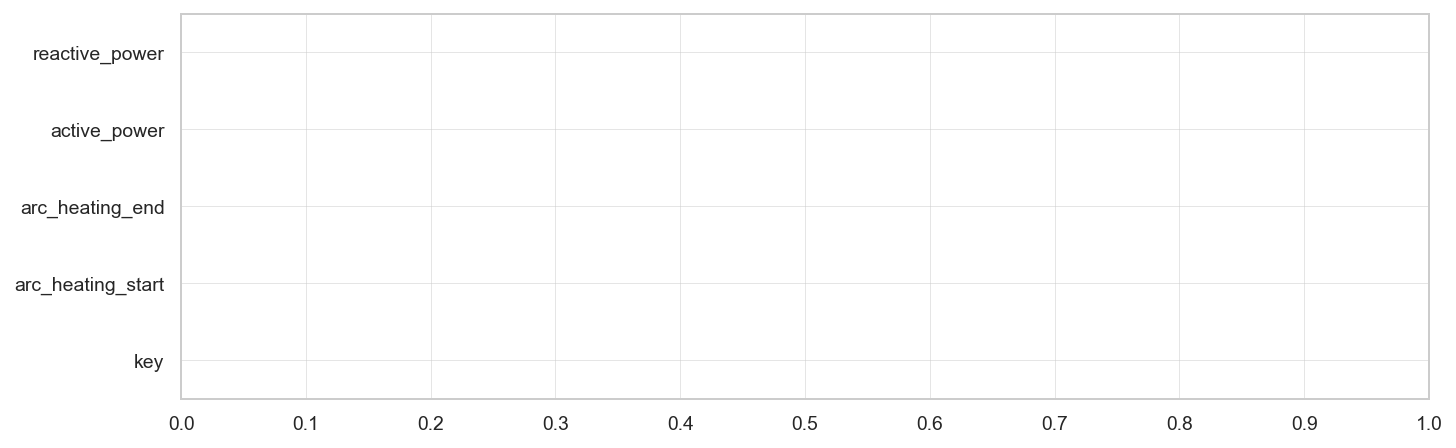

In [10]:
describe(arc)

Аномалия присутствует только в одной партии 2116.

In [11]:
arc.query('key == 2116')

,key,arc_heating_start,arc_heating_end,active_power,reactive_power
9778,2116,2019-07-24 00:29:52,2019-07-24 00:31:54,0.433,0.306
9779,2116,2019-07-24 00:35:50,2019-07-24 00:38:05,0.620,0.408
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.496,-715.505
9781,2116,2019-07-24 00:51:51,2019-07-24 00:52:58,0.299,0.199


active_power c reactive_power почти не коррелируют.

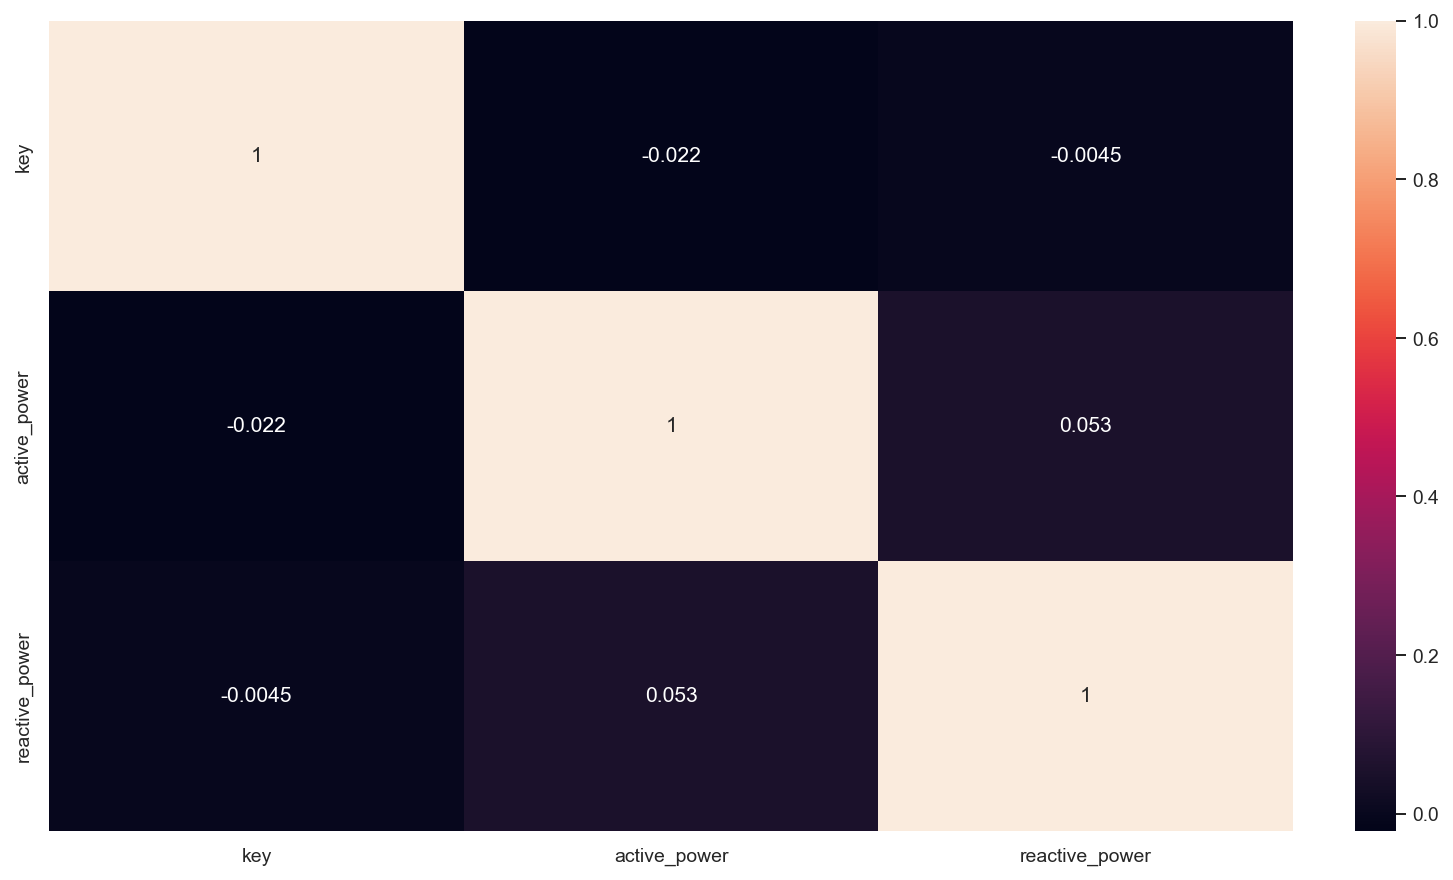

In [12]:
sns.heatmap(data=arc.corr(), annot=True);

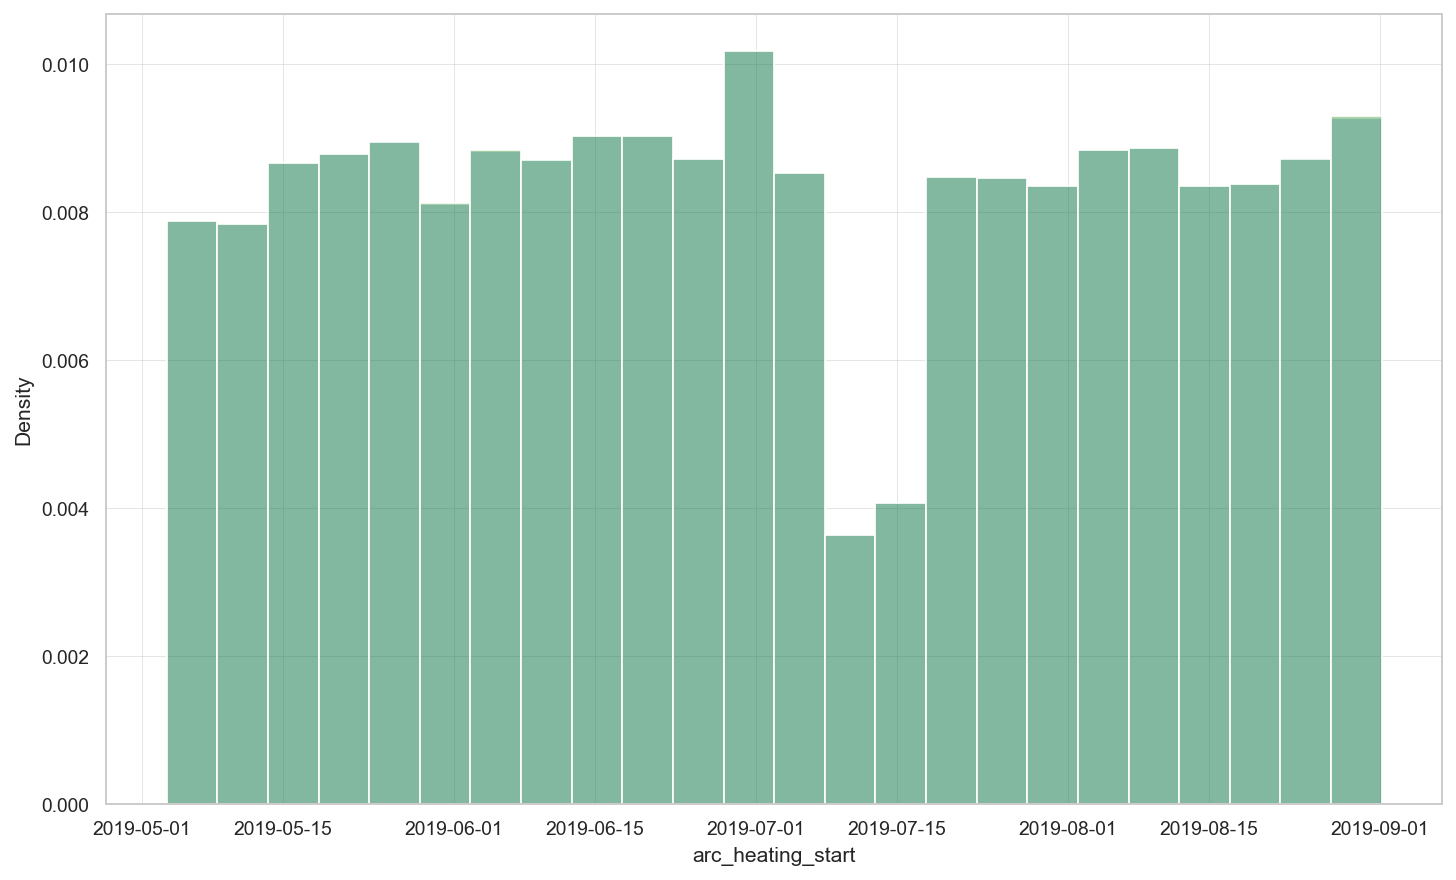

In [13]:
ax = sns.histplot(data=arc.arc_heating_start, stat='density', alpha=0.33)
sns.histplot(data=arc.arc_heating_end, stat='density', color='green', alpha=0.33, ax=ax)
plt.show()

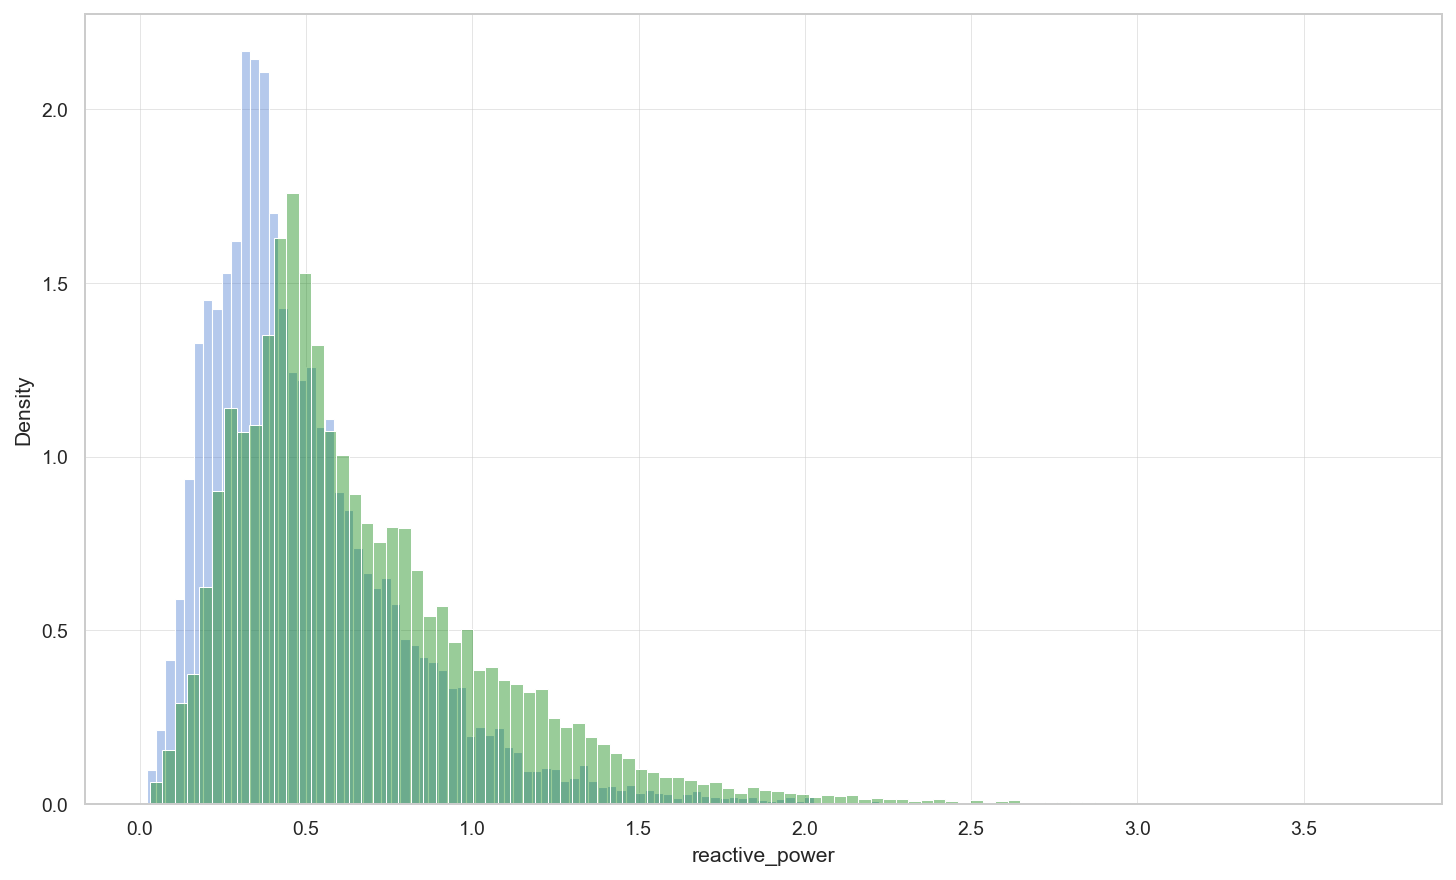

In [14]:
ax = sns.histplot(data=arc.query('reactive_power >= 0').reactive_power, stat='density', alpha=0.4)
sns.histplot(data=arc.query('reactive_power >= 0').active_power, stat='density', color='green', alpha=0.4, ax=ax)
plt.show()

### Выводы

* В данных присутствуют выбросы, так реактивная мощность сильно ниже нуля.
* Пропусков в data_arс нет, дубликаты отсутствуют.
* Наблюдается период снижения активности работы электродов.
* Распределение active_power и reactive_power соответствует логнормальному.

## Рассмотрим данные о продувке сплава газом

,key,gas_1
count,3022.000,3022.000
mean,1623.313,11.302
std,931.885,6.233
min,1.000,0.008
25%,821.250,7.282
50%,1618.500,10.016
75%,2429.750,14.078
max,3241.000,77.995



Полные дубликаты: 0



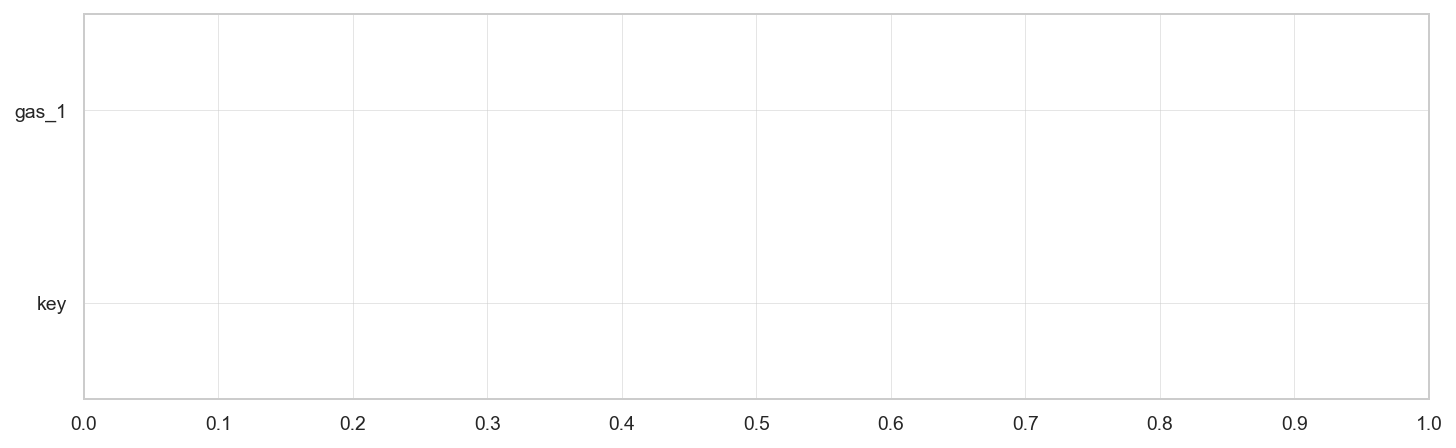

In [15]:
describe(gas)

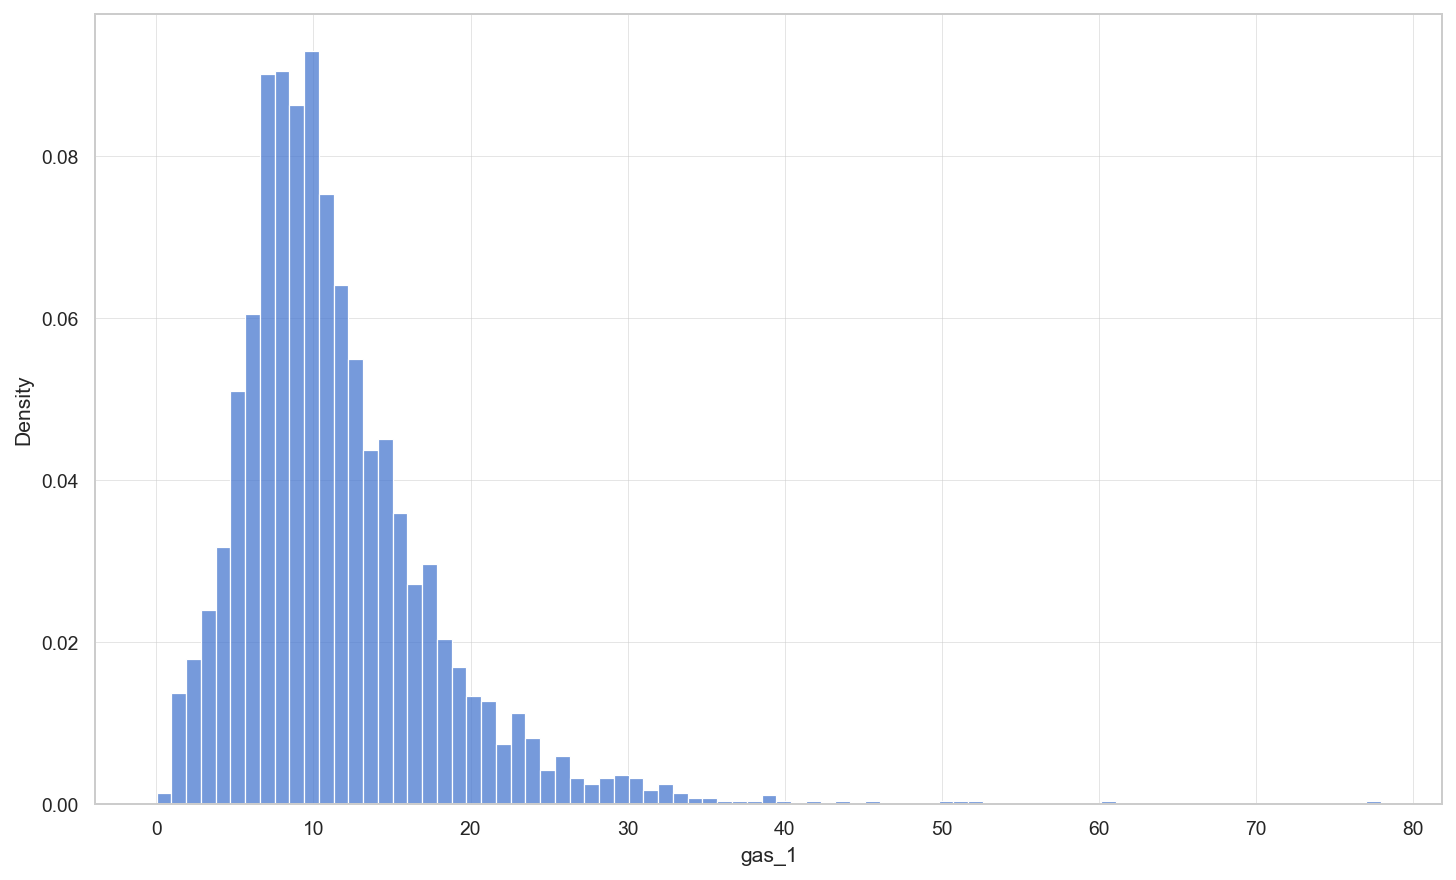

In [16]:
sns.histplot(data=gas.gas_1, stat='density');

### Выводы

* Газ выше 40 возможно связан с нарушением тех. процесса, стоит выделить такие выбросы.
* Распределение gas_1 соответствует логнормальному.

## Рассмотрим результаты измерения температуры

,key,temp
count,15048.000,12302.000
mean,1607.778,1590.154
std,939.571,18.872
min,1.000,1191.000
25%,791.000,1580.000
50%,1614.000,1591.000
75%,2426.000,1600.000
max,3241.000,1662.000



Полные дубликаты: 0



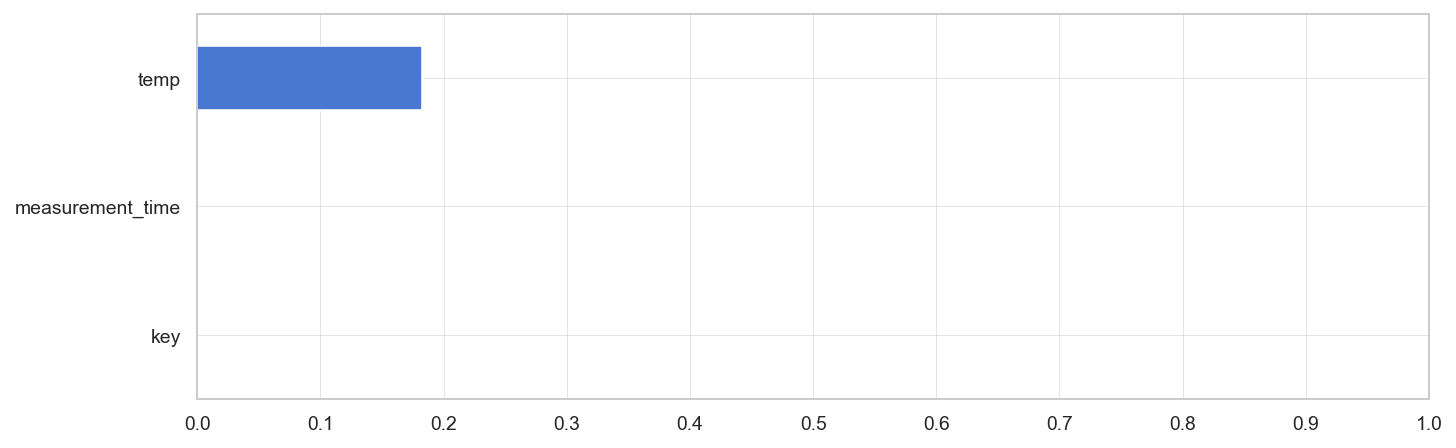

In [17]:
describe(temp)

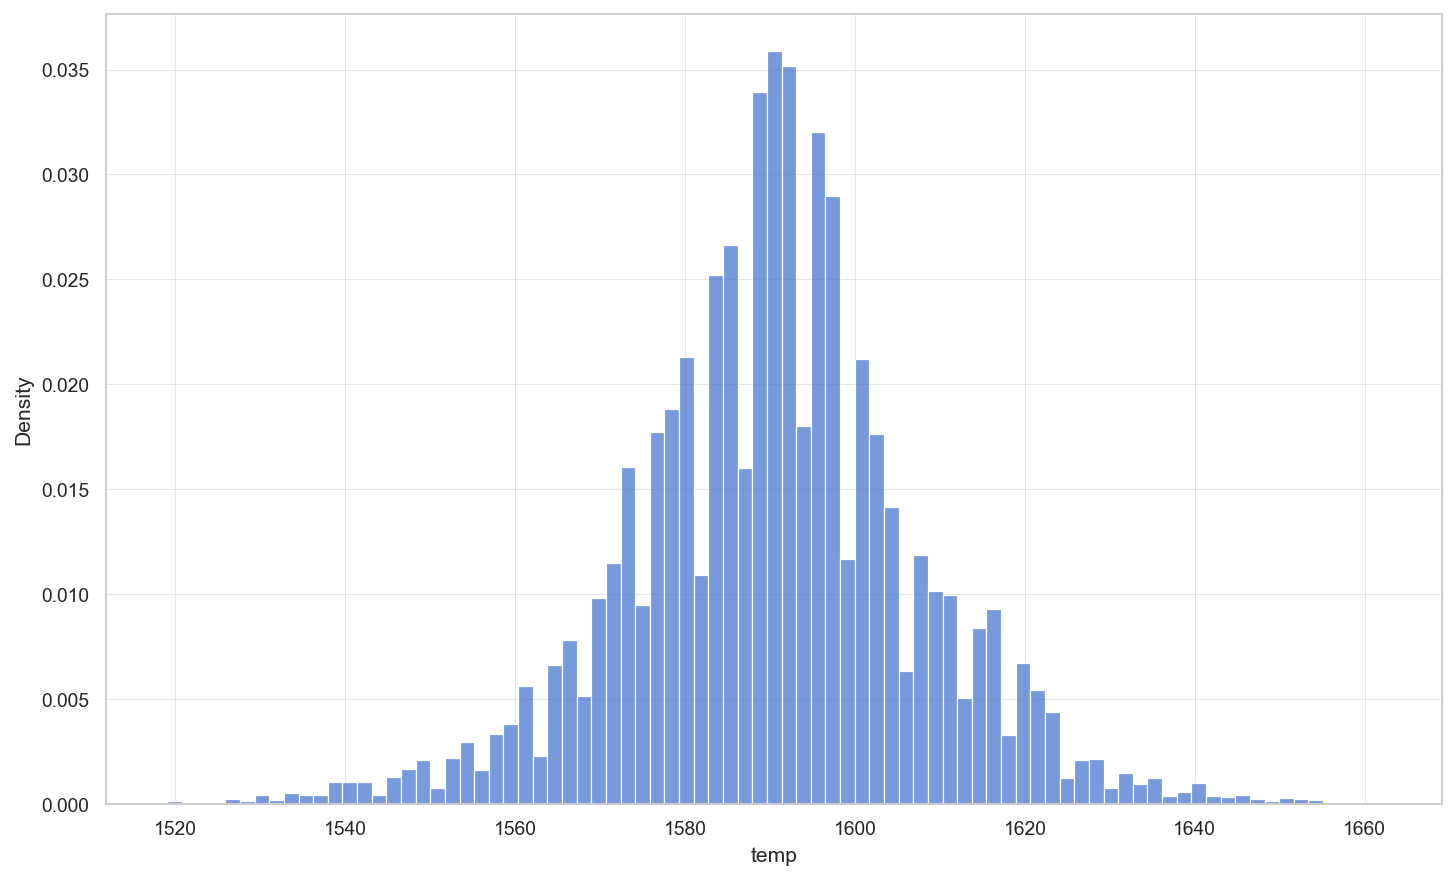

In [18]:
sns.histplot(data=temp.query('temp > 1500').temp, stat='density');

Пропуски в измеряемой температуре появляются после определенного времени и актуальны для партий с key > 2500.

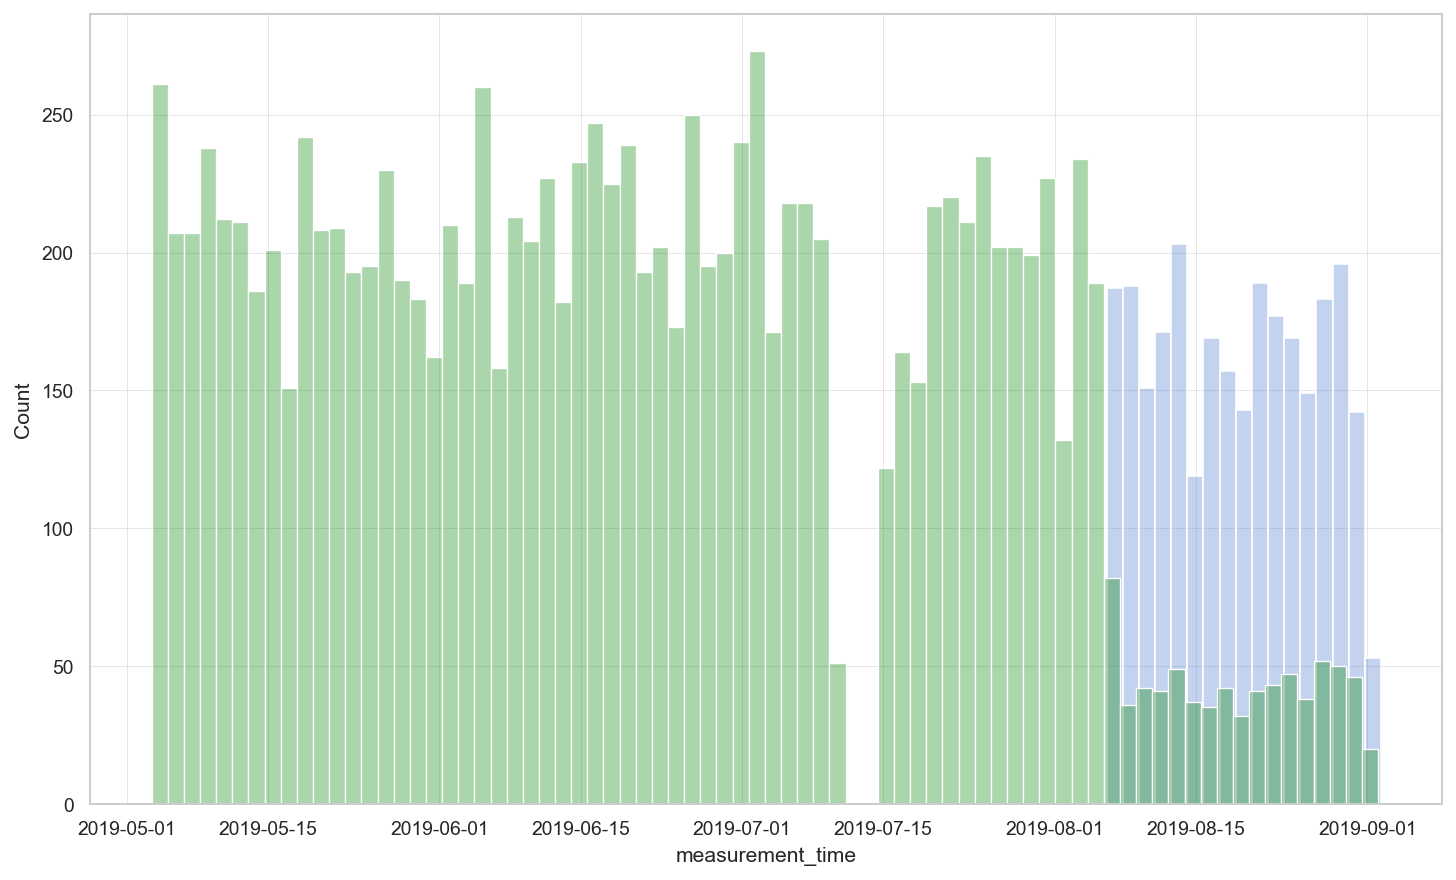

In [19]:
ax = sns.histplot(data=temp.query('temp.isna()').measurement_time,
                  stat='count', alpha=0.33, binwidth=1.6)
sns.histplot(data=temp.query('~temp.isna()').measurement_time,
             stat='count', color='green', alpha=0.33, binwidth=1.6,
             ax=ax)
plt.show()

### Выводы

* Более 15% данных содержат пропуски в температуре.
* Температуру ниже 1500 по согласованию с заказчиком принято считать аномалией.

## Рассмотрим данные о подаче сыпучих и проволочных материалах (объём и время)

In [20]:
bulk_full = pd.merge(bulk, bulk_time,
                     on='key',
                     suffixes=('', '_time'),
                     validate='one_to_one')

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,3022.000,252.000,22.000,1293.000,1012.000,77.000,570.000,24.000,1.000,19.000,176.000,177.000,2356.000,18.000,2709.000,2234.000
mean,1623.313,39.242,253.045,113.866,104.308,107.026,119.021,316.375,49.000,76.316,83.284,76.819,260.840,181.111,170.763,160.572
std,931.885,18.278,21.181,75.583,48.153,81.791,72.281,187.210,NaN,21.721,26.060,59.655,121.383,46.088,65.367,51.785
min,1.000,10.000,228.000,6.000,12.000,11.000,17.000,50.000,49.000,63.000,24.000,8.000,53.000,151.000,16.000,1.000
25%,821.250,27.000,242.000,58.000,71.750,70.000,69.250,172.250,49.000,66.000,64.000,25.000,204.000,153.250,120.000,105.000
50%,1618.500,31.000,251.500,97.000,101.500,86.000,100.000,302.000,49.000,68.000,86.500,64.000,208.000,155.500,151.000,160.500
75%,2429.750,46.000,257.750,152.000,133.000,132.000,157.000,420.000,49.000,70.500,102.000,106.000,316.000,203.500,206.000,205.000
max,3241.000,185.000,325.000,454.000,281.000,603.000,503.000,772.000,49.000,147.000,159.000,313.000,1849.000,305.000,636.000,405.000



Полные дубликаты: 0



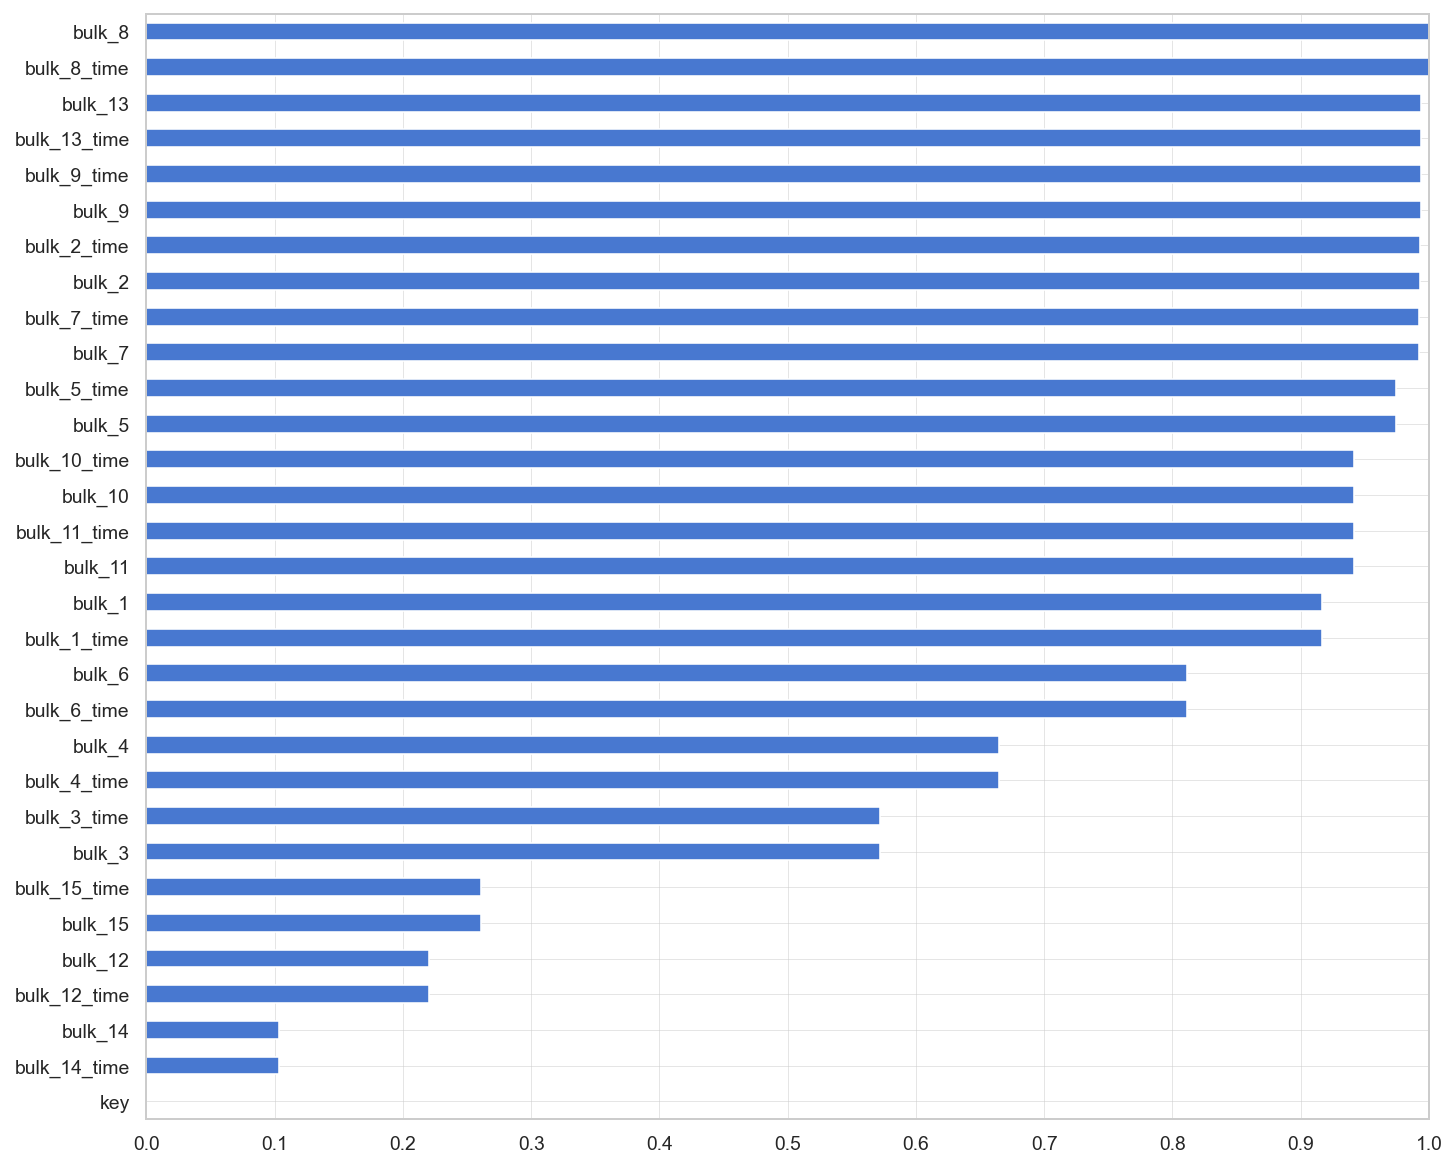

In [21]:
describe(bulk_full)

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,3022.000,2997.000,1051.000,63.000,14.000,1.000,73.000,11.000,19.000,25.000
mean,1623.313,101.143,50.480,189.483,57.443,15.132,48.017,10.039,53.625,29.852
std,931.885,41.926,39.091,99.513,28.825,NaN,33.920,8.611,16.882,15.585
min,1.000,1.919,0.030,0.144,24.149,15.132,0.034,0.234,45.077,4.623
25%,821.250,73.033,20.194,95.135,40.807,15.132,25.054,6.763,46.095,17.035
50%,1618.500,100.202,40.143,235.195,45.234,15.132,42.076,9.017,46.280,30.066
75%,2429.750,126.060,70.228,276.252,76.125,15.132,64.213,11.886,48.090,39.967
max,3241.000,330.314,282.780,385.009,113.231,15.132,180.455,32.848,102.762,62.026



Полные дубликаты: 0



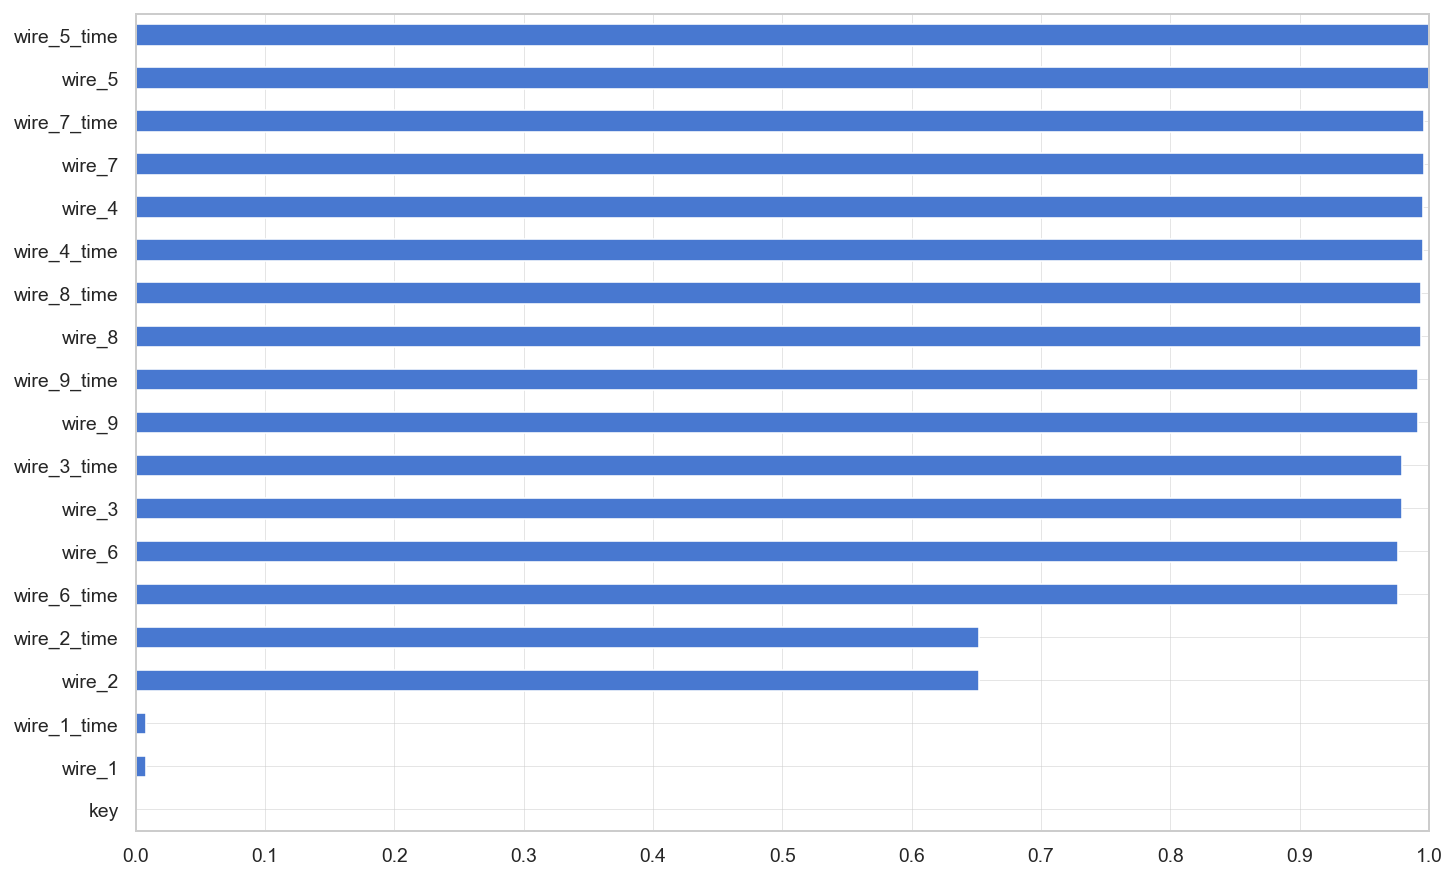

In [22]:
wire_full = pd.merge(wire, wire_time,
                     on='key',
                     suffixes=('', '_time'),
                     validate='one_to_one')
describe(wire_full)

Оценим как различаются объемы проволочных и сыпучих материалов.

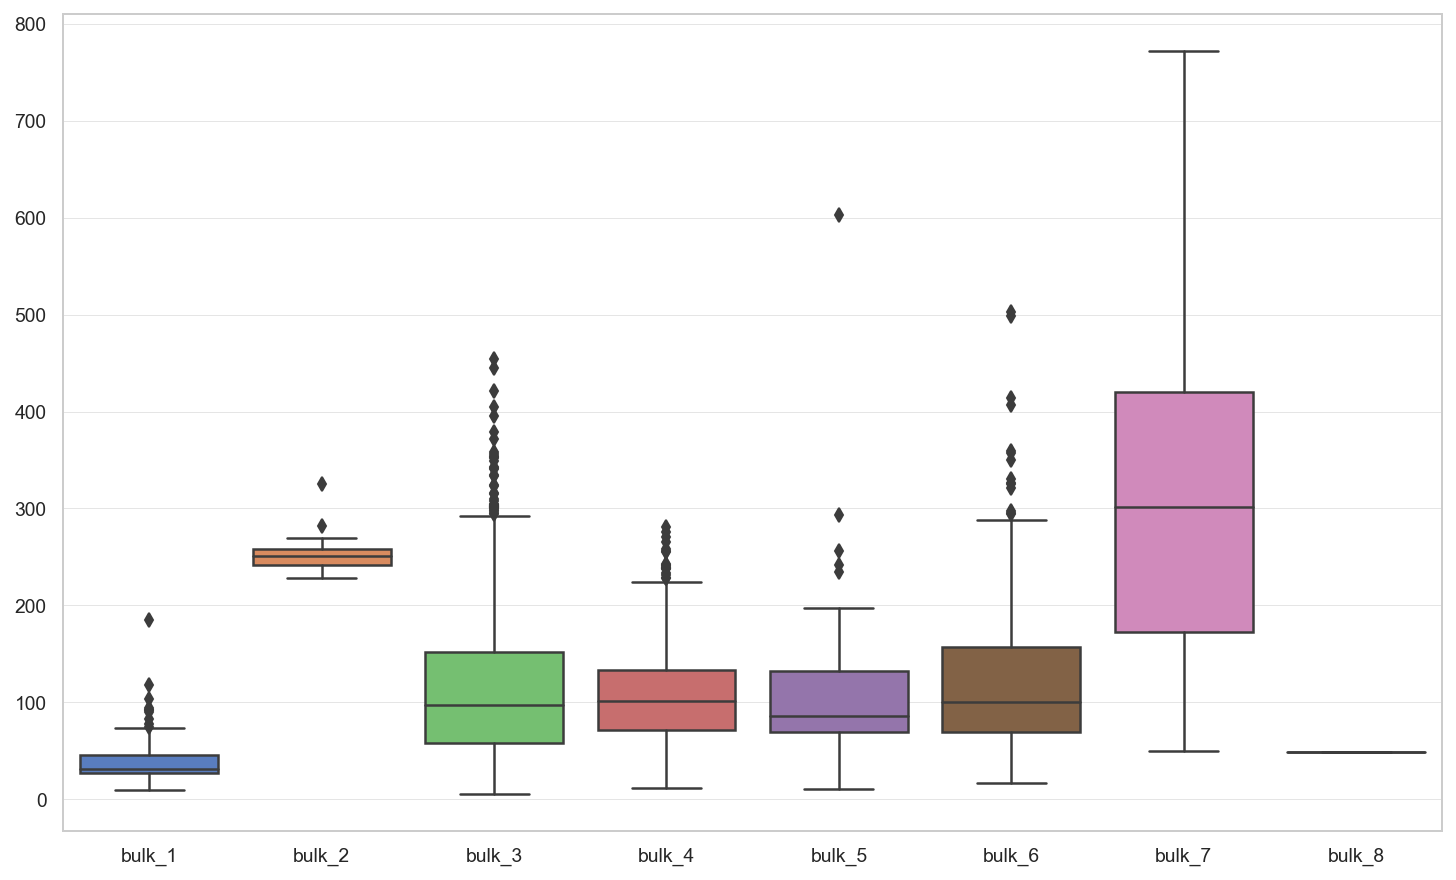

In [23]:
sns.boxplot(data=bulk_full[['bulk_1', 'bulk_2', 'bulk_3', 'bulk_4',
                            'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8']]);

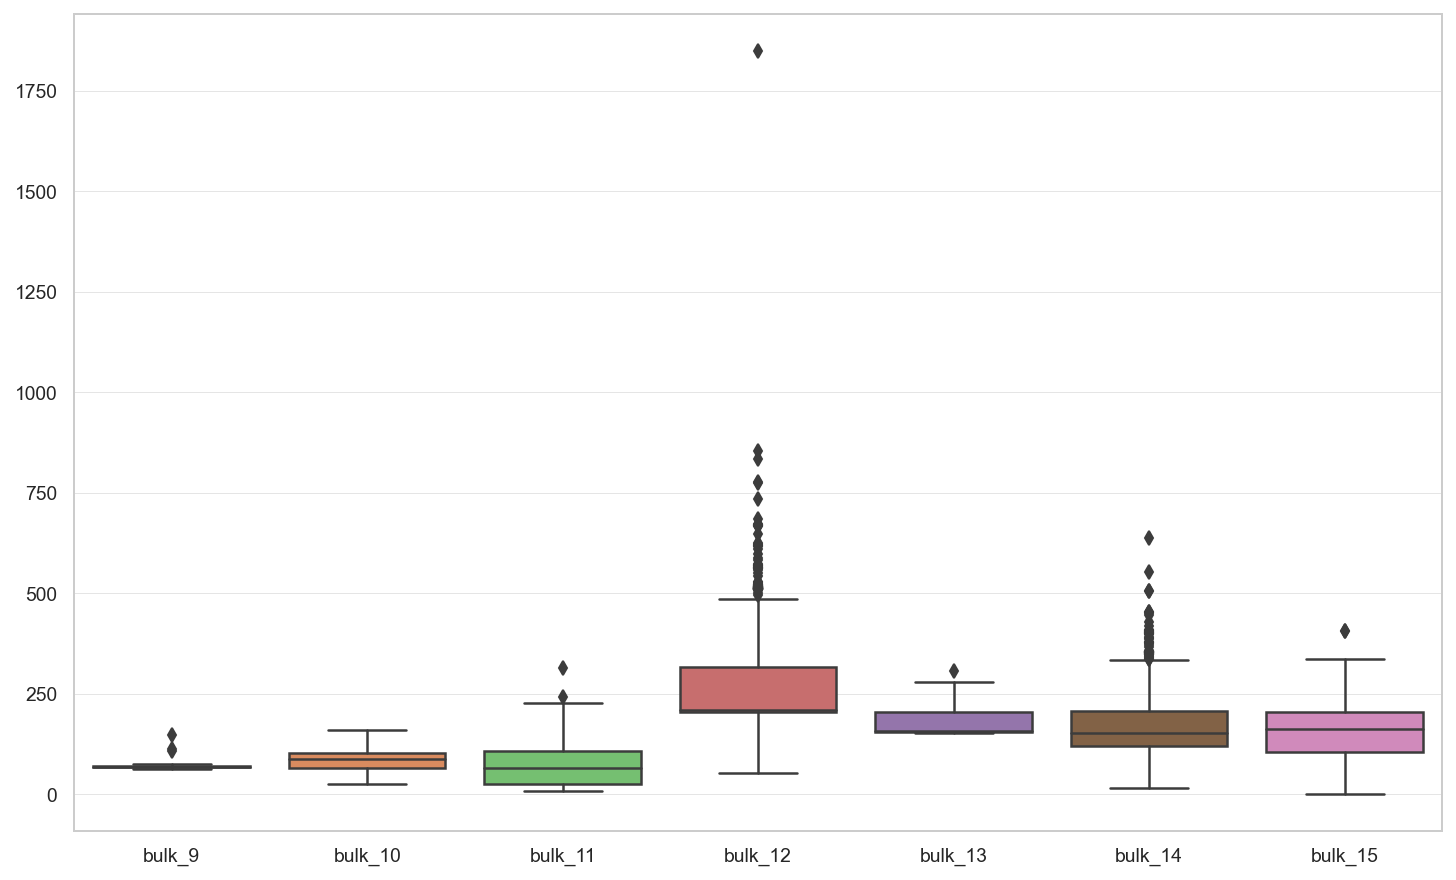

In [24]:
sns.boxplot(data=bulk_full[['bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
                            'bulk_13', 'bulk_14', 'bulk_15']]);

In [25]:
bulk_full.query('bulk_12 > 1500').iloc[:, :13]

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12
289,322,185.000,NaN,101.000,58.000,NaN,NaN,406.000,NaN,NaN,NaN,NaN,1849.000


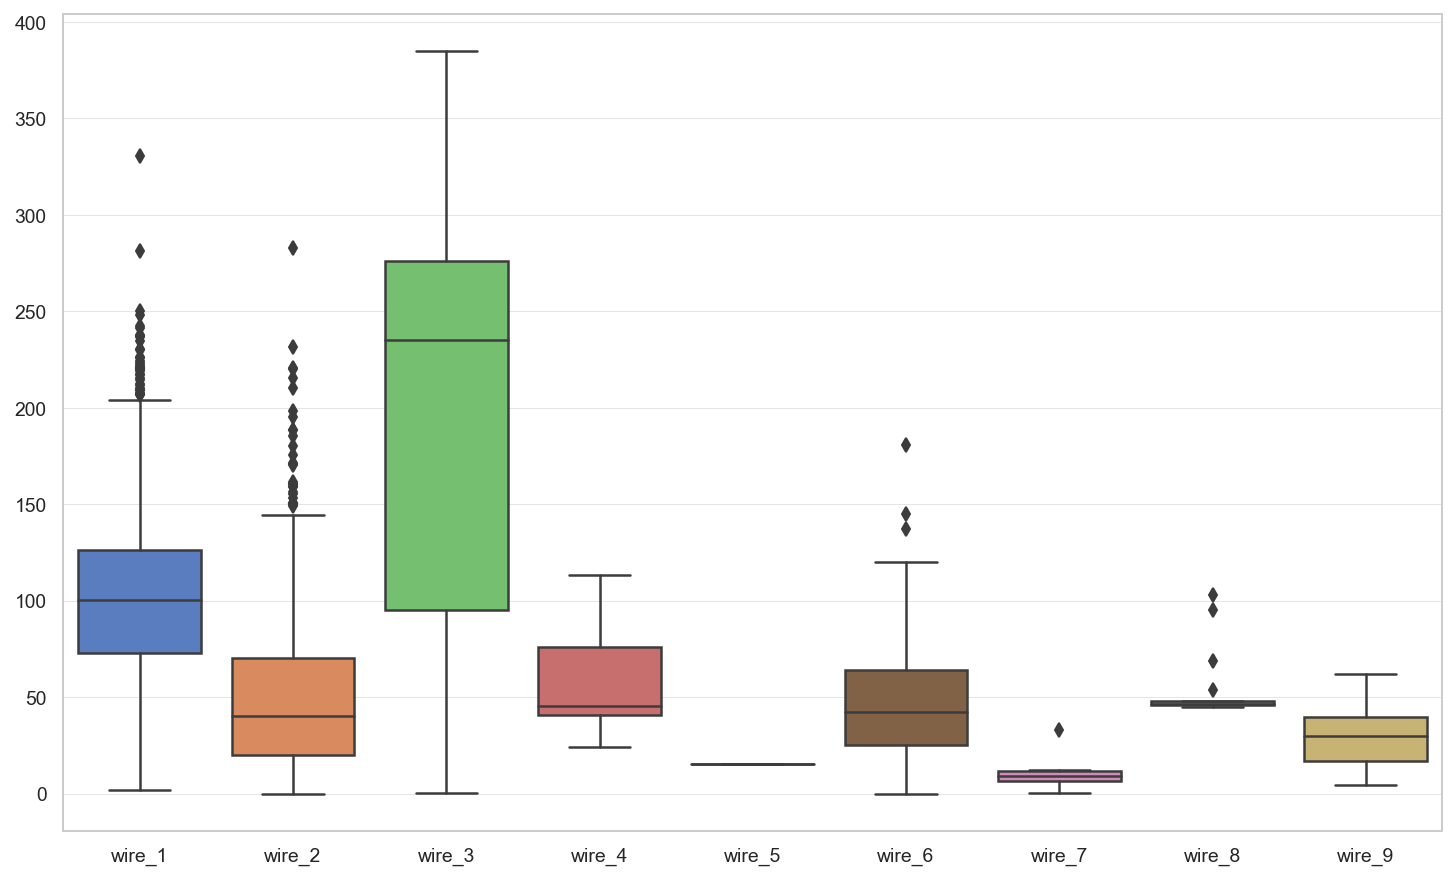

In [26]:
sns.boxplot(data=wire_full[['wire_1', 'wire_2', 'wire_3', 'wire_4',
                            'wire_5', 'wire_6', 'wire_7', 'wire_8',
                            'wire_9']]);

### Выводы

* Все пропуски в bulk и в wire означают отсутствие подачи и должны быть заполнены нулями.
* Подача компонентов может значительно различаться в зависимости от номера bulk или wire.
    * Есть выброс в bulk 12.

## Вывод

* Проведена проверка на наличие дубликатов и даны рекомендации по обработке пропусков.
    * В bulk и в wire заменяем NaN на нули.
    * Для temp пропуски удаляем. 
* Проведен исследовательский анализ данных. Обнаружены аномалии в данных.
    * Убираем аномалию в reactive_power.
    * Не учитываем данные с температурой ниже 1500 градусов.
* Возможно с августа 2019 возникла неисправность с датчиками температуры, т.к. начиная с этого времени появляются пропуски в temp.

# Feature engineering | Обработка данных 

Удалим признаки в которых слишком много пропусков.

In [27]:
bulk = bulk.dropna(axis=1, thresh=bulk.shape[0] * 0.05)
wire = wire.dropna(axis=1, thresh=wire.shape[0] * 0.05)

bulk_time = bulk_time.dropna(axis=1, thresh=bulk_time.shape[0] * 0.05)
wire_time = wire_time.dropna(axis=1, thresh=wire_time.shape[0] * 0.05)

bulk_full = bulk_full.dropna(axis=1, thresh=bulk_full.shape[0] * 0.05)
wire_full = wire_full.dropna(axis=1, thresh=wire_full.shape[0] * 0.05)

## Датафрейм df, включающий все температуры

Добавим эффективность нагрева электродами.

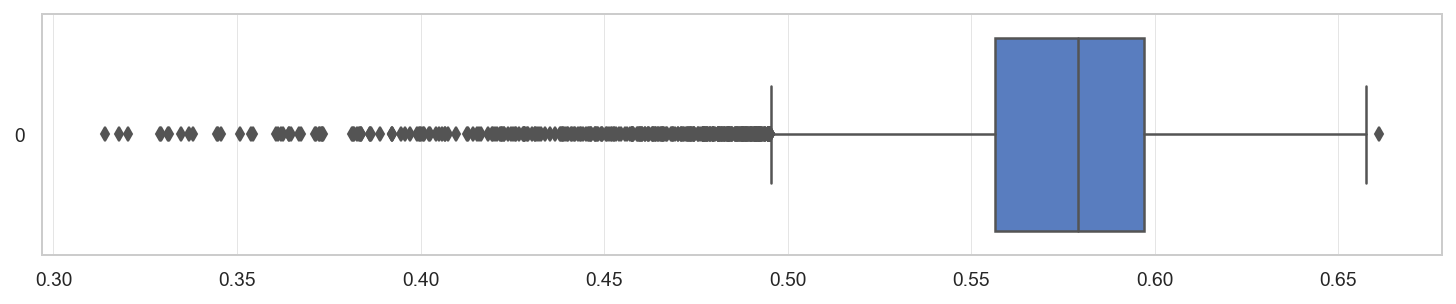

In [28]:
arc['arc_efficiency'] = arc['active_power'] / (arc['active_power'] + arc['reactive_power'])

plt.figure(figsize=(10,2))
sns.boxplot(data=arc.query('reactive_power > 0').arc_efficiency, orient='h')
plt.show()

Теперь можно исправить аномалию в reactive_power.

In [29]:
arc.loc[arc.reactive_power < 0, 'reactive_power'] = \
    arc.loc[arc.reactive_power < 0, 'active_power']  / np.median(arc['arc_efficiency']) - arc.loc[arc.reactive_power < 0, 'active_power'] 

Посчитаем полную энергию дуги и время затрачиваемое на нагрев в секундах.

In [30]:
arc['full_power'] = np.sqrt(np.power(arc['active_power'], 2) + np.power(arc['reactive_power'], 2))
arc['heating_duration'] = (arc['arc_heating_end'] - arc['arc_heating_start']).dt.seconds

Оставим партии в которых нет пропусков по температуре (все key до 2500).

Создадим новый датафрейм temp_clean.

In [31]:
keys_nan = temp[temp.temp.isna()].key.unique()
temp_clean = temp.where(temp.temp > 1500).query('~key.isin(@keys_nan)')
temp_clean.dropna(inplace=True)

Добавим время предыдущего замера температуры, это понадобится при агрегировании и объединении датафреймов.

Образовавшийся пропуск заполним самой ранней датой минус 10 минут (в дальнейшим первые объекты для ключей придется удалить, т.к требуется связка начальная-конечная температуры.

In [32]:
temp_clean['previous_measurement_time'] = temp_clean.measurement_time.shift(1)
temp_clean.previous_measurement_time = \
    temp_clean.previous_measurement_time.fillna(temp_clean.measurement_time.min() - pd.Timedelta(minutes=10))

Зададим key в качестве индекса.

In [33]:
for df in [arc, gas, temp_clean, bulk_full, wire_full]:
    df.set_index('key', inplace=True)

In [34]:
df = temp_clean.join(arc, how='left')
df = df.reset_index()

# Уберем объекты в которых замер температуры проходит в середие процесса работы дуги.
# Такой подход поможет упростить обработку мощностей.
df = df[~df.key.isin(
    df.query('measurement_time < arc_heating_end and measurement_time > arc_heating_start').key.unique()
)]
df.key = df.key.astype(int)

print(df.shape, end='\n\n')
df.head()

(57413, 11)



,key,measurement_time,temp,previous_measurement_time,arc_heating_start,arc_heating_end,active_power,reactive_power,arc_efficiency,full_power,heating_duration
0,1,2019-05-03 11:16:18,1571.000,2019-05-03 11:06:18,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976,0.687,0.587,1.194,228
1,1,2019-05-03 11:16:18,1571.000,2019-05-03 11:06:18,2019-05-03 11:07:28,2019-05-03 11:10:33,0.806,0.520,0.608,0.959,185
2,1,2019-05-03 11:16:18,1571.000,2019-05-03 11:06:18,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744,0.499,0.599,0.896,172
3,1,2019-05-03 11:16:18,1571.000,2019-05-03 11:06:18,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659,1.063,0.610,1.970,365
4,1,2019-05-03 11:16:18,1571.000,2019-05-03 11:06:18,2019-05-03 11:26:09,2019-05-03 11:28:37,0.693,0.414,0.626,0.807,148


С агрегируем данные, для каждого периода [previous_measurement_time, measurement_time] найдем требуемые параметры.

In [35]:
def aggregator(group):
    temp = group['temp'].values[0]
    previous_measurement_time = group['previous_measurement_time'].values[0]
    
    group = group.query('arc_heating_start > previous_measurement_time and arc_heating_end <= measurement_time')
    
    avg_active_power = np.mean(group['active_power'])
    avg_reactive_power = np.mean(group['reactive_power'])
    sum_full_power = np.sum(group['full_power'])
    heating_cnt = group.shape[0]
    sum_heating_duration = np.sum(group['heating_duration'])
    avg_arc_efficiency = np.mean(group['arc_efficiency'])
    
    return pd.Series(
        {
            'previous_measurement_time': previous_measurement_time,
            'temp': temp,
            'avg_active_power': avg_active_power,
            'avg_reactive_power': avg_reactive_power,
            'sum_full_power': sum_full_power,
            'heating_cnt': heating_cnt,
            'sum_heating_duration': sum_heating_duration,
            'avg_arc_efficiency': avg_arc_efficiency,
        }
    )

Объединим df c bulk_full, wire_full.

In [36]:
df = df.groupby(['key', 'measurement_time']).apply(aggregator)

# Сбросим мультииндекс ['key', 'measurement_time'] и установим 'key'.
df.reset_index(inplace=True)
df.set_index('key', inplace=True)
df = df.join([bulk_full, wire_full], how='left')

Посчитаем длительность процесса.

In [37]:
df['process_duration'] = (df['measurement_time'] - df['previous_measurement_time']).dt.seconds

Добавки распределим по временным периодам их подачи.

In [38]:
# Разделим wire и bulk на две составляющие: объем и время.
wire_half = len(wire_full.columns) // 2
for item in zip(wire_full.columns[wire_half:], wire_full.columns[:wire_half]):
    df[item[1]] = df.where((df[item[0]] <= df['measurement_time']) & (df['previous_measurement_time'] < df[item[0]]))[item[1]]
    
bulk_half = len(bulk_full.columns) // 2
for item in zip(bulk_full.columns[bulk_half:], bulk_full.columns[:bulk_half]):
    df[item[1]] = df.where((df[item[0]] <= df['measurement_time']) & (df['previous_measurement_time'] < df[item[0]]))[item[1]]


df.drop(columns=wire_full.columns[wire_half:].tolist() + bulk_full.columns[bulk_half:].tolist(), inplace=True)

Так как в таблице gas нет времени, то будем считать что газ поступал с постоянным по времени расходом.

In [39]:
def aggregator(group):
    return pd.Series(
        {
            'gas_per_second': group['gas_1'].values[0] / np.sum(group['process_duration'])
        }
    )

# Получив расход в секунду для каждого key умножим его на продолжительность процесса.
# В результате получим gas_1 за период [previous_measurement_time, measurement_time].
df['gas_1'] = df.process_duration * df.join(gas.join(df[['process_duration']],
                                                     how='right').groupby('key').apply(aggregator))['gas_per_second']

Заполним пропуски в bulk и wire нулями.

In [40]:
df.fillna(0, inplace=True)

Выделим конечную и начальную температуры.

In [41]:
df['starting_temp'] = df.temp.shift(1)
df.rename(columns={'temp': 'ending_temp'}, inplace=True)

Найдем суммы подачи сыпучих и проволочных материалов, а также число таких добавок к каждой партии.

In [42]:
df['wire_sum'] = df[wire_full.columns[:wire_half]].sum(axis=1)
df['wire_cnt'] = df[wire_full.columns[:wire_half]].apply(raw=True, axis=1, func=np.count_nonzero)
df['bulk_sum'] = df[bulk_full.columns[:bulk_half]].sum(axis=1)
df['bulk_cnt'] = df[bulk_full.columns[:bulk_half]].apply(raw=True, axis=1, func=np.count_nonzero)

Время больше не требуется, удалим measurement_time и previous_measurement_time.

In [43]:
df.drop(columns=['measurement_time', 'previous_measurement_time'], inplace=True)

Так как в каждой партии у нас нет начальной температуры, а только конечная, то для каждого key удаляем первое значение.

In [44]:
df.reset_index(inplace=True)

df['mark'] = df.groupby('key').cumcount()
df = df.query('mark > 0')

df.set_index('key', inplace=True)
df.drop(columns=['mark'], inplace=True)

Итоговый датафрейм.

In [45]:
print(df.shape, end='\n\n')
with pd.option_context('display.max_columns', None):
    display(df.head())

(9204, 25)



,ending_temp,avg_active_power,avg_reactive_power,sum_full_power,heating_cnt,sum_heating_duration,avg_arc_efficiency,bulk_1,bulk_3,bulk_4,bulk_6,bulk_10,bulk_11,bulk_12,bulk_14,bulk_15,wire_1,wire_2,process_duration,gas_1,starting_temp,wire_sum,wire_cnt,bulk_sum,bulk_cnt
key,,,,,,,,,,,,,,,,,,,,,,,,,
1,1604.000,1.659,1.063,1.970,1,365,0.610,0.000,0.000,43.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,575,11.709,1571.000,0.000,0,43.000,1
1,1618.000,0.693,0.414,0.807,1,148,0.626,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,198,4.032,1604.000,0.000,0,0.000,0
1,1601.000,0.000,0.000,0.000,0,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,50,1.018,1618.000,0.000,0,0.000,0
1,1613.000,0.000,0.000,0.000,0,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,38,0.774,1601.000,0.000,0,0.000,0
2,1577.000,0.000,0.000,0.000,0,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,33,0.242,1581.000,0.000,0,0.000,0


## Датафрейм df_full, в котором есть только начальная и конечная температуры

Посчитаем суммарные добавки сыпучих и проволочных материалах.

In [46]:
# Пропуски заполним нулями.
bulk.fillna(0, inplace=True)
wire.fillna(0, inplace=True)
bulk_full.fillna(0, inplace=True)
wire_full.fillna(0, inplace=True)

bulk['bulk_sum'] = bulk.iloc[:, 1:].apply(raw=True, axis=1, func='sum')
bulk['bulk_cnt'] = bulk.iloc[:, 1:-1].apply(raw=True, axis=1, func=np.count_nonzero)

wire['wire_sum'] = wire.iloc[:, 1:].apply(raw=True, axis=1, func='sum')
wire['wire_cnt'] = wire.iloc[:, 1:-1].apply(raw=True, axis=1, func=np.count_nonzero)

Из гистограммы видно, что нагрев в среднем занимает порядка 3 минут.

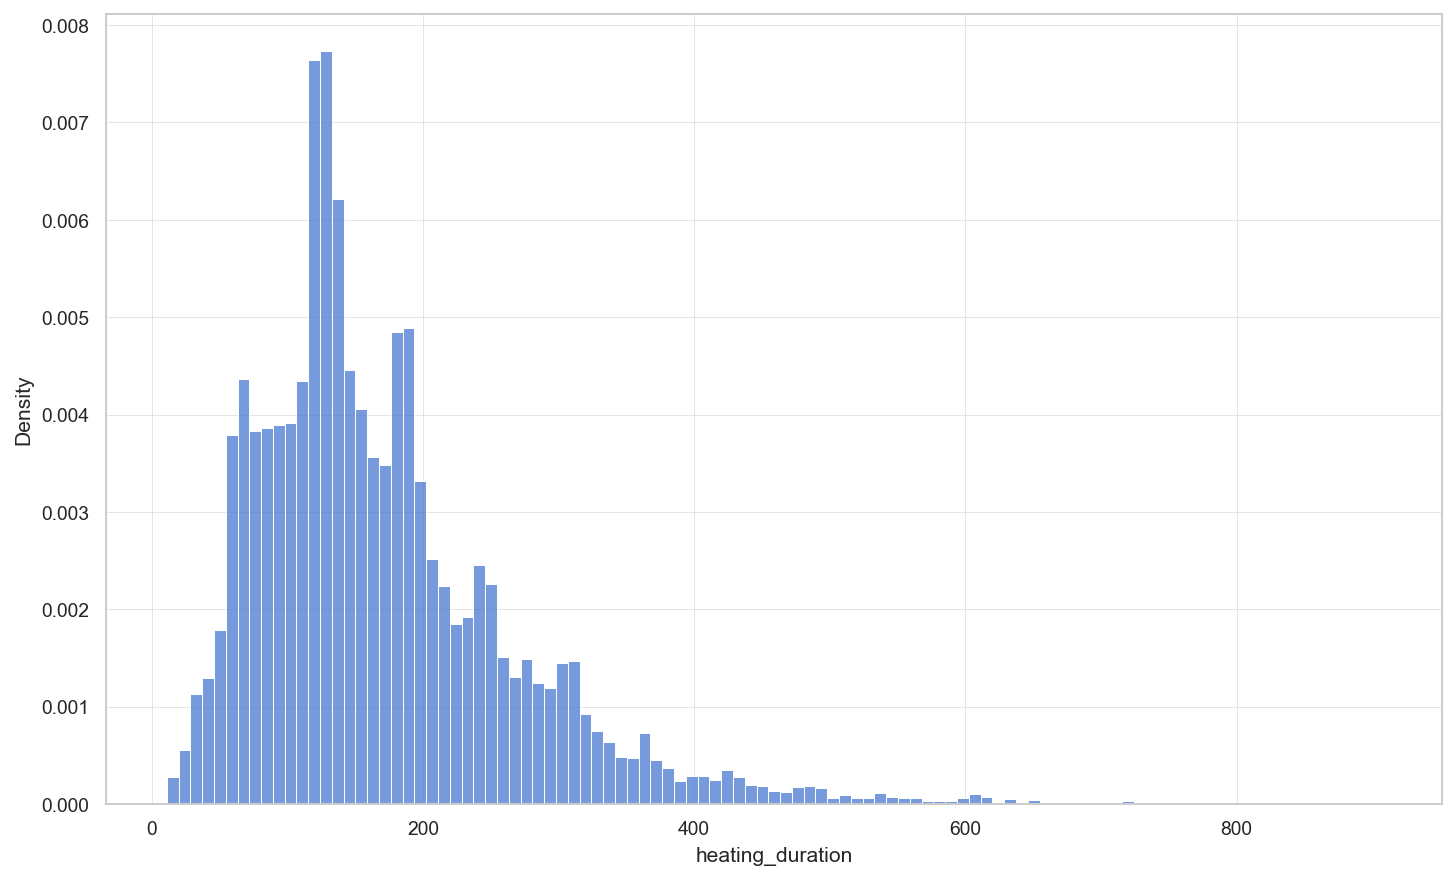

In [47]:
sns.histplot(data=arc.heating_duration, stat='density');

Сгруппируем данные об электродах по key.

In [48]:
def arc_aggregator(group):
    avg_active_power = np.mean(group['active_power'])
    avg_reactive_power = np.mean(group['reactive_power'])
    sum_full_power = np.sum(group['full_power'])
    heating_cnt = group.shape[0]
    sum_heating_duration = np.sum(group['heating_duration'])
    avg_arc_efficiency = np.mean(group['arc_efficiency'])
    
    return pd.Series(
        {
            'avg_active_power': avg_active_power,
            'avg_reactive_power': avg_reactive_power,
            'sum_full_power': sum_full_power,
            'heating_cnt': heating_cnt,
            'sum_heating_duration': sum_heating_duration,
            'avg_arc_efficiency': avg_arc_efficiency,
        }
    )

arc_grouped = arc.groupby('key').apply(arc_aggregator).reset_index()
arc_grouped.head()

,key,avg_active_power,avg_reactive_power,sum_full_power,heating_cnt,sum_heating_duration,avg_arc_efficiency
0,1,0.976,0.637,5.826,5.000,1098.000,0.606
1,2,0.763,0.500,3.649,4.000,811.000,0.608
2,3,0.505,0.320,2.990,5.000,655.000,0.613
3,4,0.802,0.515,3.815,4.000,741.000,0.609
4,5,0.837,0.563,4.036,4.000,869.000,0.597


Выполним FE для измерений температуры

In [49]:
def temp_aggregator(group):
    group = group.where(temp.temp > 1500)
    
    # Оставим партии в которых первая и последняя температуры не NaN.
    if ~np.isnan(group.iloc[0, 2]) and ~np.isnan(group.iloc[-1, 2]):
        starting_temp = group.iloc[0, 2]
        ending_temp = group.iloc[-1, 2]
        process_duration = (group.iloc[-1, 1] - group.iloc[0, 1]).seconds
    else:
        starting_temp = np.nan
        ending_temp = np.nan
        process_duration = np.nan
    
    return pd.Series(
        {
            'starting_temp': starting_temp,
            'ending_temp': ending_temp,
            'process_duration': process_duration
        }
    )

temp_grouped = temp.groupby('key').apply(temp_aggregator).reset_index()
temp_grouped.dropna(inplace=True)
temp_grouped.head()

,key,starting_temp,ending_temp,process_duration
0,1,1571.000,1613.000,861.000
1,2,1581.000,1602.000,1305.000
2,3,1596.000,1599.000,1300.000
3,4,1601.000,1625.000,388.000
4,5,1576.000,1602.000,762.000


Визуализируем новые признаки.

* Есть партии в которых время замера между начальной и конечной температурой достигает более 1.5 часов (5400 секунд).

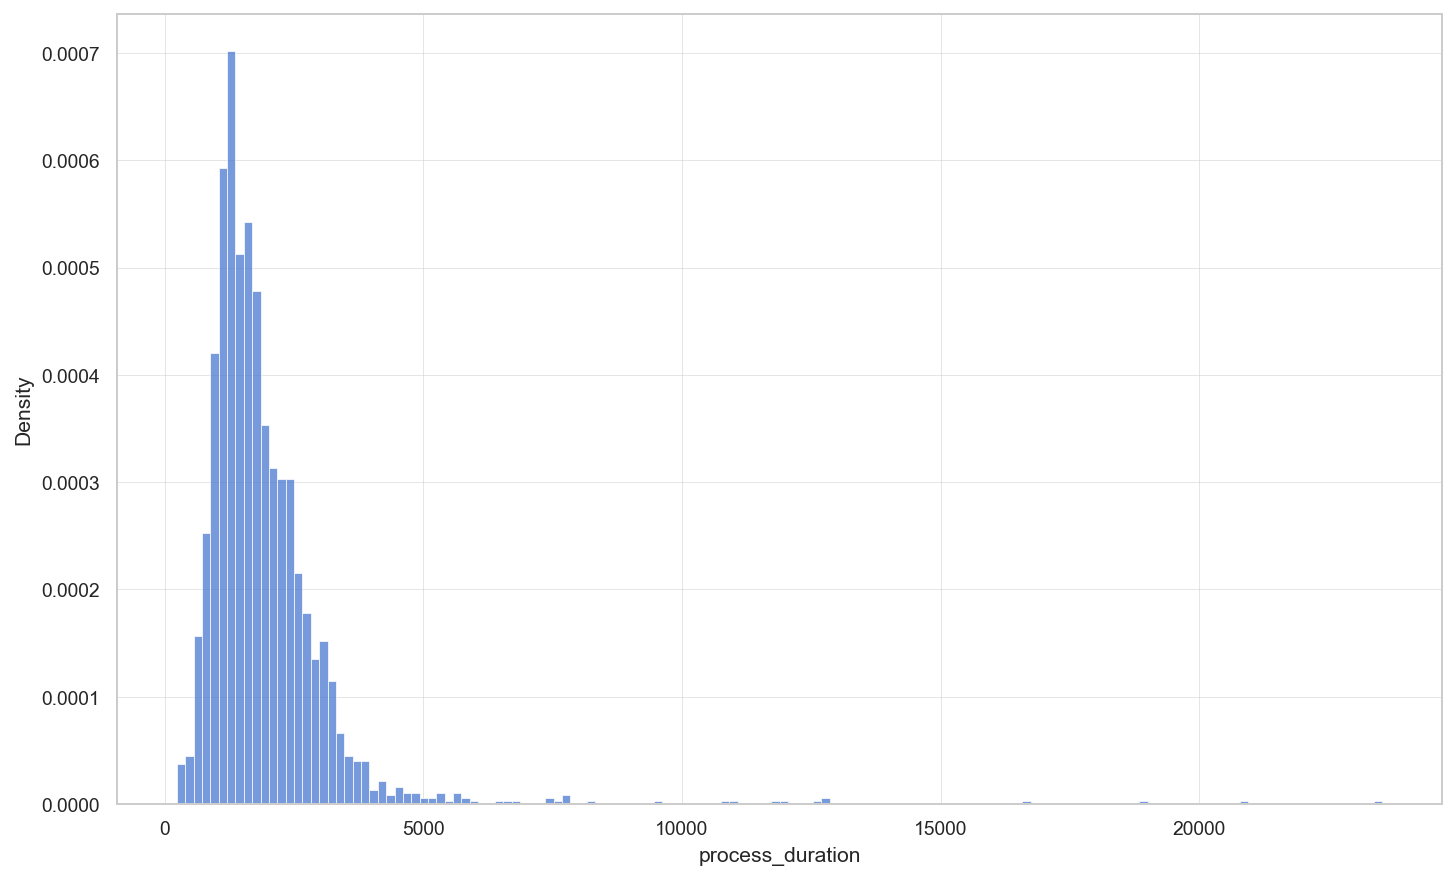

In [50]:
sns.histplot(data=temp_grouped.process_duration, stat='density');

Сыпучие материалы добавляют чаще чем проволоку. Различны и формы распределения данных признаков.

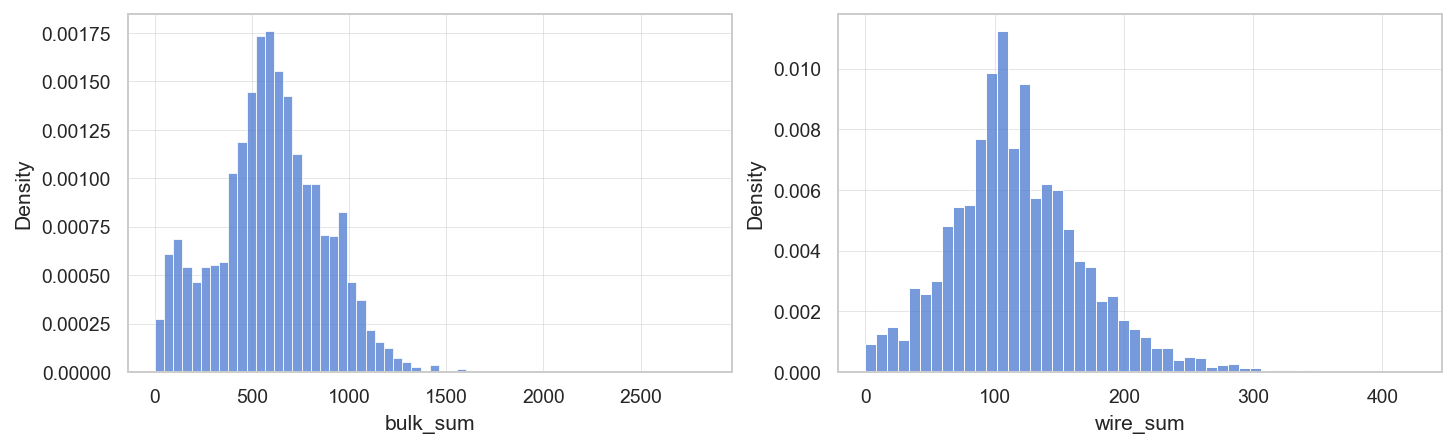

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(10,3))
sns.histplot(data=bulk.bulk_sum, stat='density', ax=axes[0])
sns.histplot(data=wire.wire_sum, stat='density', ax=axes[1])
plt.show()

Зададим key в качестве индекса и объединим все данные.

In [52]:
for dataframe in [arc_grouped, temp_grouped, bulk, wire]:
    dataframe.set_index('key', inplace=True)
    
df_full = arc_grouped.join([gas, temp_grouped, bulk, wire], how='inner')

print(df_full.shape, end='\n\n')
with pd.option_context('display.max_columns', None):
    display(df_full.head())

(2325, 25)



,avg_active_power,avg_reactive_power,sum_full_power,heating_cnt,sum_heating_duration,avg_arc_efficiency,gas_1,starting_temp,ending_temp,process_duration,bulk_1,bulk_3,bulk_4,bulk_6,bulk_10,bulk_11,bulk_12,bulk_14,bulk_15,bulk_sum,bulk_cnt,wire_1,wire_2,wire_sum,wire_cnt
key,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.976,0.637,5.826,5.000,1098.000,0.606,29.750,1571.000,1613.000,861.000,0.000,0.000,43.000,0.000,0.000,0.000,206.000,150.000,154.000,553.000,4,60.060,0.000,60.060,1
2,0.763,0.500,3.649,4.000,811.000,0.608,12.556,1581.000,1602.000,1305.000,0.000,0.000,73.000,0.000,0.000,0.000,206.000,149.000,154.000,582.000,4,96.052,0.000,96.052,1
3,0.505,0.320,2.990,5.000,655.000,0.613,28.555,1596.000,1599.000,1300.000,0.000,0.000,34.000,0.000,0.000,0.000,205.000,152.000,153.000,544.000,4,91.160,0.000,91.160,1
4,0.802,0.515,3.815,4.000,741.000,0.609,18.841,1601.000,1625.000,388.000,0.000,0.000,81.000,0.000,0.000,0.000,207.000,153.000,154.000,595.000,4,89.064,0.000,89.064,1
5,0.837,0.563,4.036,4.000,869.000,0.597,5.414,1576.000,1602.000,762.000,0.000,0.000,78.000,0.000,0.000,0.000,203.000,151.000,152.000,584.000,4,89.238,9.115,98.353,2


Признаки в df и df_full одинаковые.

In [53]:
set(df.columns) ^ set(df_full.columns)

set()

## Вывод

* Сгенерированы новые фичи.
* Проведена предобработка данных.
* Сформированы два сборных датафрейма.

# Моделирование

> Будем использовать три модели: два бустинга и одну линейную модель.

Разделим выборку на train, valid и test.

Тестирование проведем по двум тестовым выборкам:
* Первая - предсказание конечной температуры при известной начальной.
* Вторая - предсказание следующей промежуточной температуры.

In [54]:
X = df_full.drop('ending_temp', axis=1)
y = df_full['ending_temp']

X, X_test_1, y, y_test_1 = train_test_split(
    X, y, test_size=test_size, random_state=random_state)
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.05, random_state=random_state)

print(X_train.shape, X_valid.shape)

(1655, 24) (88, 24)


В df_full индекс key уникальный, поэтому дополним каждую выборку датафреймом df.

In [55]:
X_train = pd.concat([X_train, df.loc[set(X_train.index) & set(df.index),:].drop('ending_temp', axis=1)], ignore_index=True)
X_valid = pd.concat([X_valid, df.loc[set(X_valid.index) & set(df.index),:].drop('ending_temp', axis=1)], ignore_index=True)

y_train = pd.concat([y_train, df.loc[set(y_train.index) & set(df.index),:]['ending_temp']], ignore_index=True)
y_valid = pd.concat([y_valid, df.loc[set(y_valid.index) & set(df.index),:]['ending_temp']], ignore_index=True)

X_test_2 = df.loc[set(X_test_1.index) & set(df.index),:].drop('ending_temp', axis=1)
y_test_2 = df.loc[set(y_test_1.index) & set(df.index),:]['ending_temp']

print(X_train.shape, X_valid.shape)

(8131, 24) (460, 24)


In [56]:
print(X_test_1.shape, X_test_2.shape)

(582, 24) (2346, 24)


## Линейная модель

Линейная модель показывает хороший результат за счет правильного подбора фичей.

MAE для lasso равно 5.7 на кросс-валидации.

In [57]:
sc = StandardScaler()

X_sc_train = sc.fit_transform(pd.concat([X_train, X_valid]))
y_sc_train = pd.concat([y_train, y_valid])
X_sc_test = sc.transform(X_test_1)

Коэффициенты линейной регресии.

* Заметно, что основной вклад вносят: полная мощность, начальная температура и продолжительность процесса.

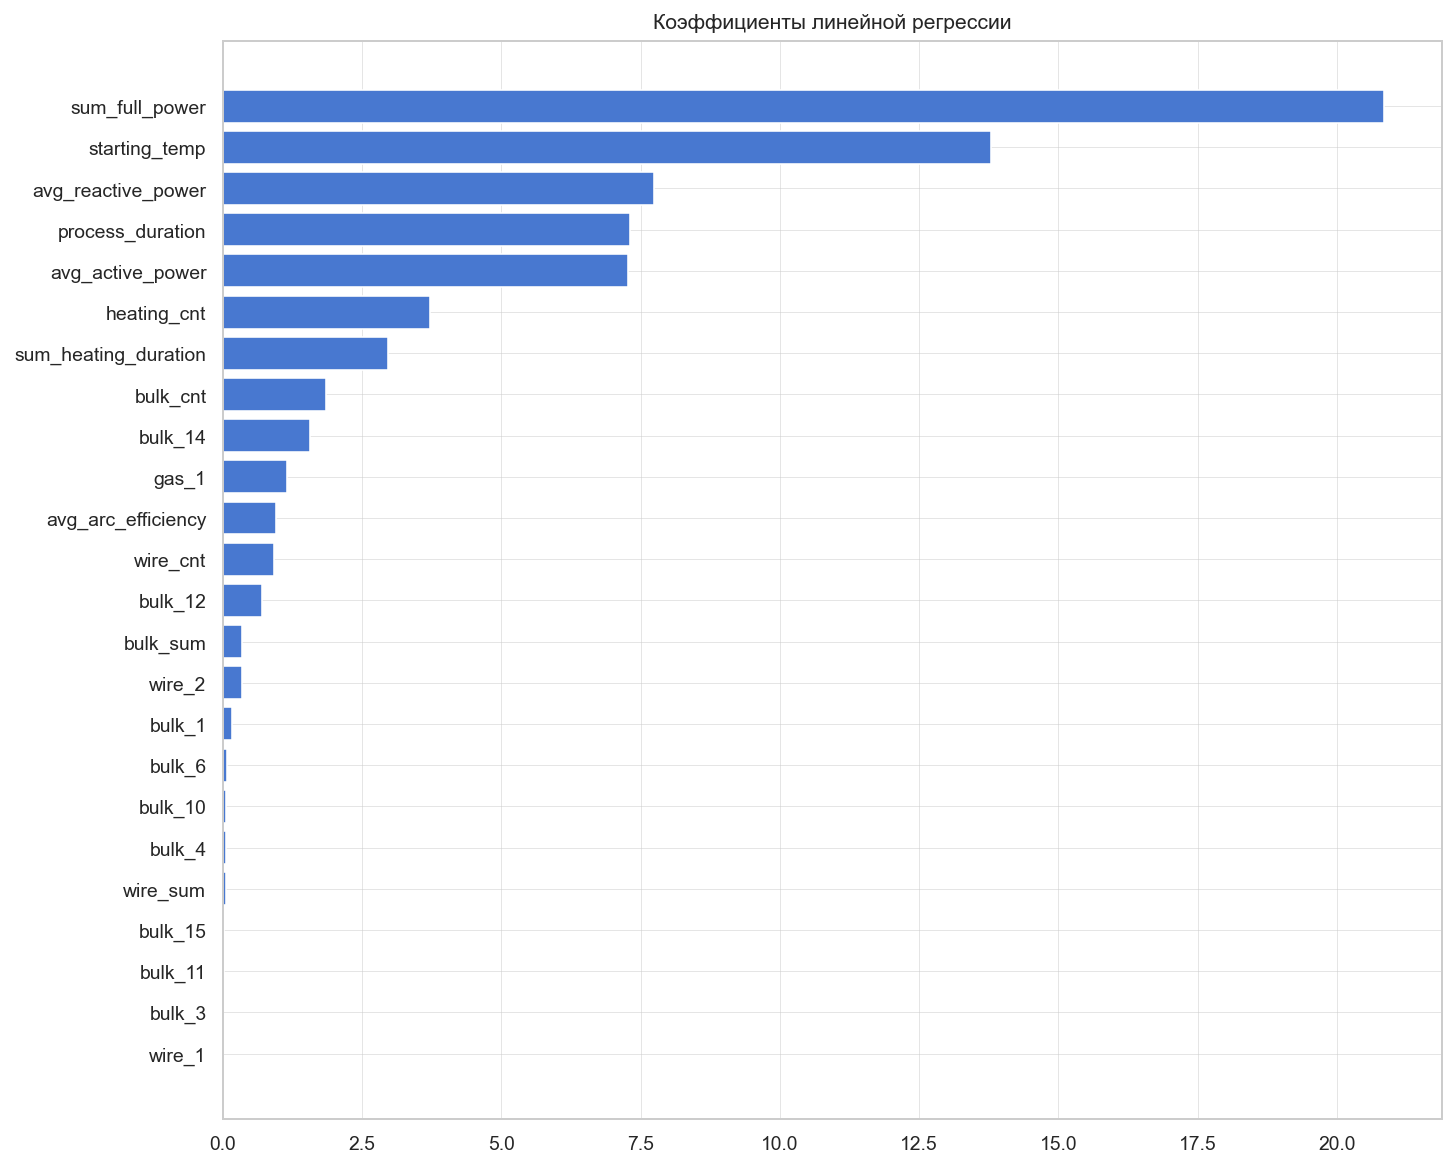

In [58]:
lasso = LassoCV(cv=5, max_iter=2000, random_state=random_state).fit(X_sc_train, y_sc_train)

sorted_idx = np.argsort(np.abs(lasso.coef_))
lasso_coef = np.abs(lasso.coef_)
fig = plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_idx)), lasso_coef[sorted_idx])
plt.yticks(range(len(sorted_idx)), np.array(X_train.columns)[sorted_idx])
plt.title('Коэффициенты линейной регрессии')
plt.show()

Результаты кросс-валидации для линейной модели.

In [59]:
cv_score = cross_val_score(Lasso(alpha=lasso.alpha_, max_iter=2000),
                           X_sc_train,
                           y_sc_train,
                           cv=5,
                           scoring='neg_mean_absolute_error') * -1
print(f'MAE для кросс-валидации: {cv_score.mean():.4f}')

MAE для кросс-валидации: 5.7348


## LightGBM

LightGBM улучшает результат до 4.9.

In [60]:
train_set = lgb.Dataset(X_train, label=y_train)
valid_set = lgb.Dataset(X_valid, label=y_valid)

In [61]:
def objective(trial):
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'verbose': -1,
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'seed': 38,
        
    }
 
    model = lgb.train(params=params,
                      train_set=train_set,
                      valid_sets=valid_set,
                      callbacks=[lgb.early_stopping(100, verbose=False), lgb.log_evaluation(period=0)])
    y_hat = model.predict(X_valid)
    return mean_absolute_error(y_valid, y_hat)
 
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20);

print('Оптимальные гиперпараметры:', study.best_trial.params)
print(f'Лучший MAE: {study.best_value:.4f}')

Оптимальные гиперпараметры: {'max_depth': 8, 'colsample_bytree': 0.8530008257238679}
Лучший MAE: 4.4300


In [62]:
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'verbose':-1,
    'seed': 38,
}
params.update(study.best_trial.params)

cv_score = cross_val_score(lgb.LGBMRegressor(**params),
                           pd.concat([X_train, X_valid]),
                           pd.concat([y_train, y_valid]),
                           cv=5,
                           scoring='neg_mean_absolute_error') * -1
print(f'MAE для кросс-валидации: {cv_score.mean():.4f}')

MAE для кросс-валидации: 4.8832


Оценка важности фичей и их влияния на целевую переменную.

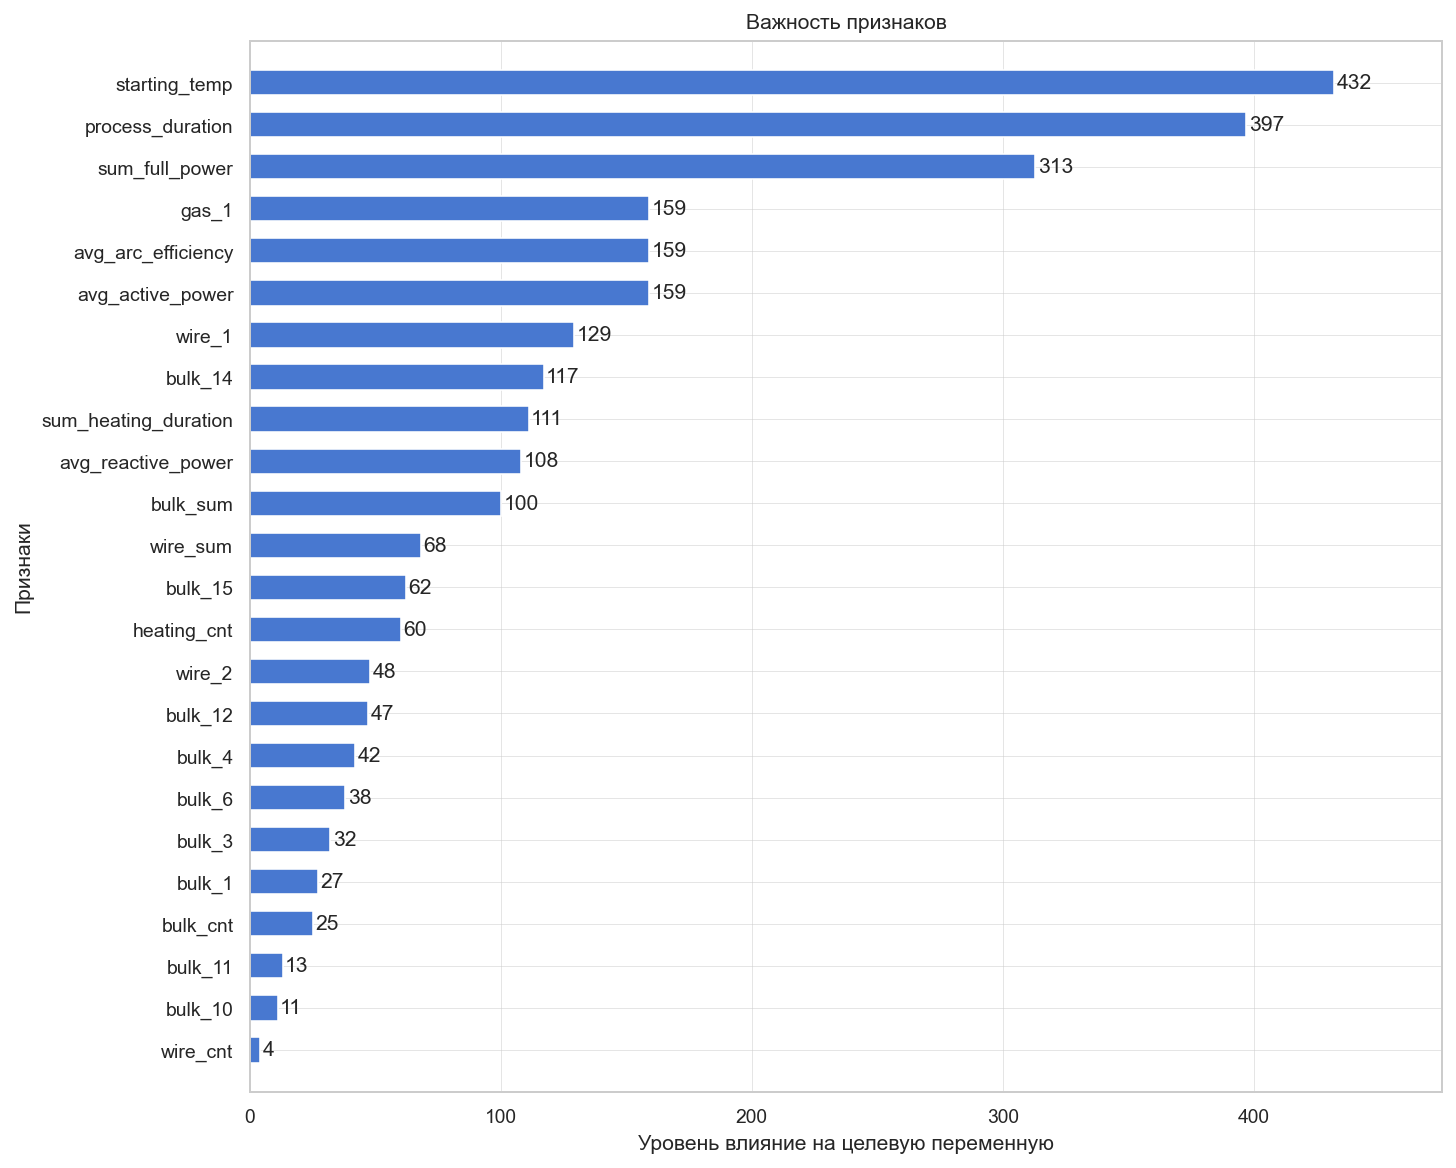

In [63]:
lgbm = lgb.train(params=params,
                 train_set=train_set,
                 valid_sets=valid_set,
                 callbacks=[lgb.early_stopping(100, verbose=False), lgb.log_evaluation(period=0)])

lgb.plot_importance(lgbm, figsize=(10,8), height=0.6,
                    title='Важность признаков',
                    xlabel='Уровень влияние на целевую переменную',
                    ylabel='Признаки');

## CatBoost

Подберем оптимальные параметры используя RandomizedSearchCV.

In [64]:
# Сетка гиперпараметров для подбора.
param_grid = {
    'subsample': np.linspace(0.5, 1, 11),
    'depth': range(2, 8),
    'max_bin': range(100, 500, 10),
    'learning_rate': [0.03, 0.05, 0.1],
}

cat_booster = CatBoostRegressor(verbose=False,
                                eval_metric='MAE',
                                random_state=38)

search = RandomizedSearchCV(
    cat_booster,
    param_grid,
    cv=5,
    n_iter=30,
    scoring='neg_mean_absolute_error',
    random_state=random_state,
    n_jobs=-1,
)

search.fit(
    pd.concat([X_train, X_valid]),
    pd.concat([y_train, y_valid])
)
print('Оптимальные гиперпараметры:', search.best_params_)

Оптимальные гиперпараметры: {'subsample': 0.75, 'max_bin': 390, 'learning_rate': 0.05, 'depth': 5}


Результат кросс-валидации.

In [65]:
cv_score = search.cv_results_['mean_test_score'][
    search.cv_results_['rank_test_score'].argmin()] *-1
print(f'MAE для кросс-валидации: {cv_score.mean():.4f}')

MAE для кросс-валидации: 4.6157


CatBoost выдает лучшую MAE на CV.

In [66]:
train_dataset = Pool(data=X_train,
                     label=y_train)
eval_dataset = Pool(data=X_valid,
                    label=y_valid)

search.best_estimator_.fit(train_dataset,
                           eval_set=eval_dataset,
                           early_stopping_rounds=150,
                           verbose=250)

0:	learn: 10.0848331	test: 9.9162436	best: 9.9162436 (0)	total: 5.35ms	remaining: 5.35s
250:	learn: 4.3780012	test: 4.5582032	best: 4.5582032 (250)	total: 555ms	remaining: 1.66s
500:	learn: 3.9609514	test: 4.3607621	best: 4.3607621 (500)	total: 1.16s	remaining: 1.15s
750:	learn: 3.7385538	test: 4.3364806	best: 4.3353210 (744)	total: 1.66s	remaining: 552ms
999:	learn: 3.5781628	test: 4.3229749	best: 4.3229570 (995)	total: 2.16s	remaining: 0us

bestTest = 4.32295698
bestIteration = 995

Shrink model to first 996 iterations.


МАE на тестовых выборках:

In [67]:
y_hat = search.best_estimator_.predict(X_test_1)
print(f'MAE на 1 тестовой выборке: {mean_absolute_error(y_test_1, y_hat):.4f}')

MAE на 1 тестовой выборке: 5.4337


In [68]:
y_hat = search.best_estimator_.predict(X_test_2)
print(f'MAE на 2 тестовой выборке: {mean_absolute_error(y_test_2, y_hat):.4f}')

MAE на 2 тестовой выборке: 4.1886


Построим график влиянияние фичей на целевую переменную.

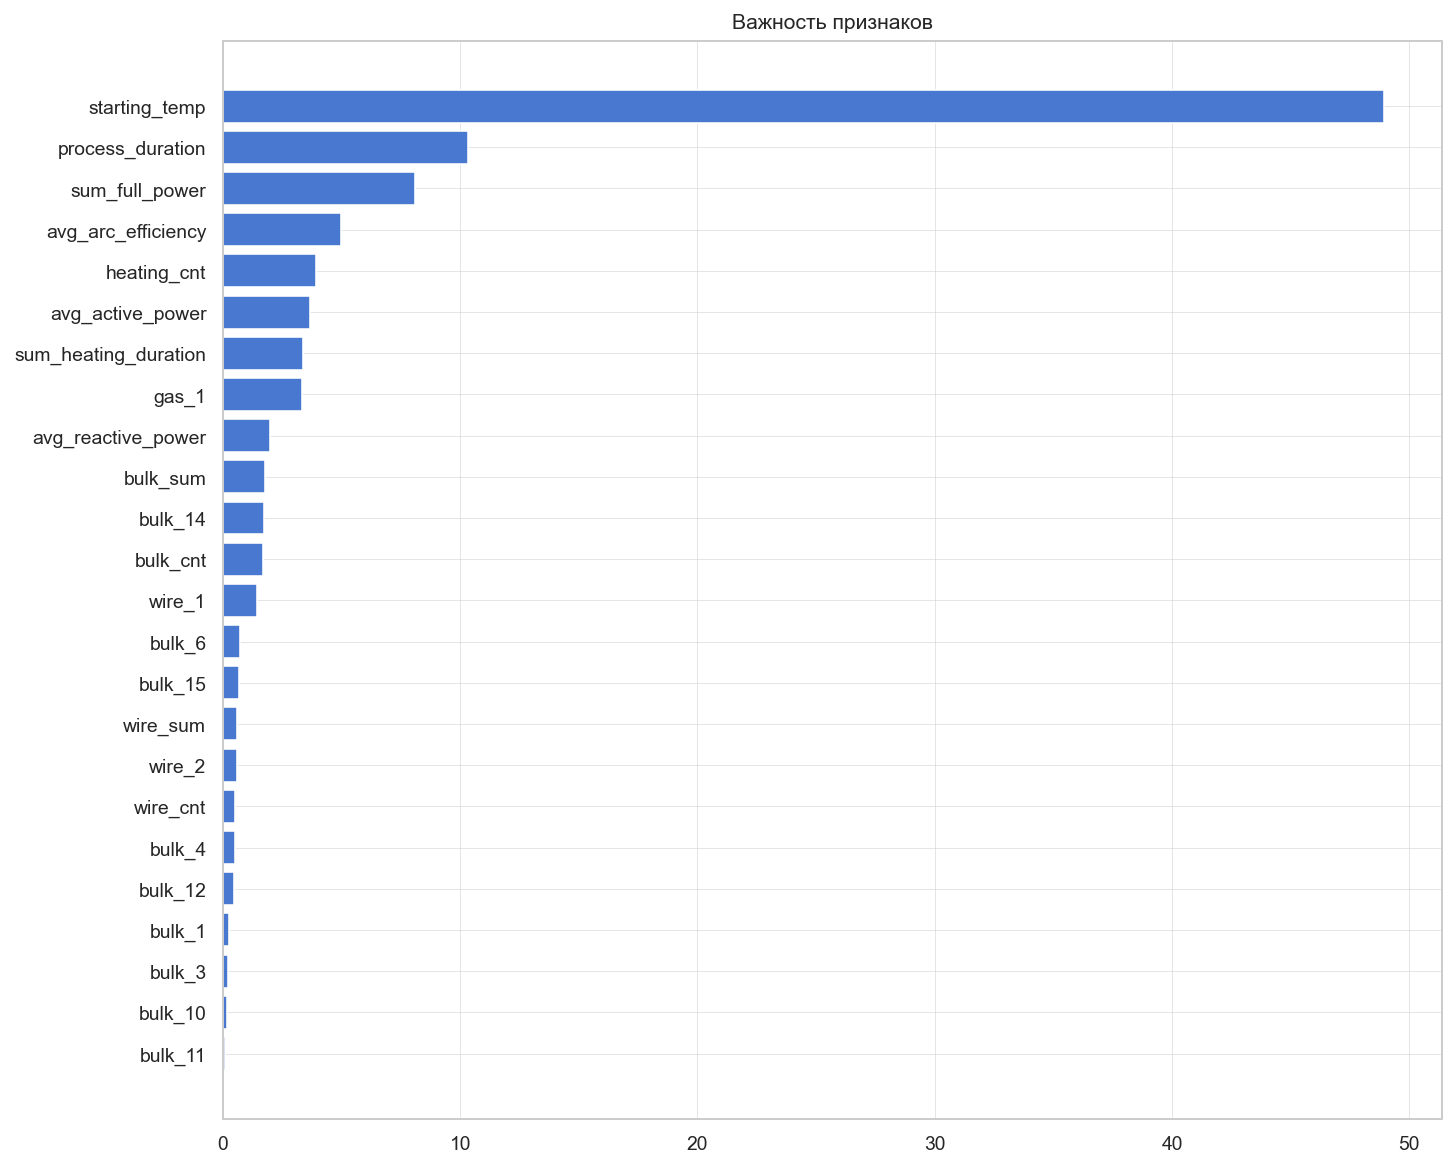

In [69]:
feature_importance = search.best_estimator_.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_train.columns)[sorted_idx])
plt.title('Важность признаков')
plt.show()

## Константная модель DummyRegressor

Лучшая MAE для константоной модели достигается при использовании медианного значения, DummyRegressor выдает метрику 8.3.

In [70]:
y_hat = DummyRegressor(strategy='median').fit(X_sc_train, y_sc_train).predict(X_sc_test)
print(f'MAE на тестовой выборке: {mean_absolute_error(y_test_1, y_hat):.4f}')

MAE на тестовой выборке: 8.2784


# Вывод

* Проведено моделирование для трех различных моделей.
* Выбрана лучшая модель – CatBoostRegressor, MAE составило 5.4, 4.2 с параметрами subsample=0.75, depth=5, learning_rate=0.05 и max_bin=390 при loss_function=RMSE.
* Определены признаки оказывающие наибольшее влияние на целевую переменную:
    * Начальная температура.
    * Длительность процесса.
    * Суммарная мощность.
    * Эффективность дуги.